<h1>Lymphocyte Gating</h1>

Testing the performance of Immunova's automated gating algorithms at detecting lymphocyte populations gated using forward and sideward scatter. The accuracy, sensitivity, specificity and F1 score will be reported for each sample and then summarised as the average across all samples.

In [2]:
import sys
if '/home/rossco/immunova' not in sys.path:
    sys.path.append('/home/rossco/immunova')
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating
from immunova.flow.gating.defaults import ChildPopulationCollection
from immunova.flow.plotting.static_plots import Plot
from immunova.data.mongo_setup import test_init
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from datetime import datetime
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import pandas as pd
import numpy as np
import functools
import warnings
warnings.filterwarnings('ignore')
test_init()

In [3]:
def visualise_manual_ellipse(data, x, y, centroid, width, height, angle, xlim, ylim):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist2d(data[x], data[y], bins=500, norm=LogNorm())
    ellipse = Ellipse(xy=centroid, width=width, height=height,
                              angle=angle, fill=False, edgecolor='r')
    ax.add_patch(ellipse)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    fig.show()

In [4]:
exp = FCSExperiment.objects(experiment_id='ILTIS_T1').get()

In [2]:
x = pd.read_csv('algo_performance.csv')
gating_performance = x.to_dict('list')

def audited_apply(sample_go, gate_name, manual_pop):
    # Apply function and measure time taken
    start = datetime.now()
    sample_go.apply(gate_name=gate_name)
    end = datetime.now()
    gating_performance['sample_id'].append(sample_go.id)
    gating_performance['method'].append(gate_name)
    gating_performance['time'].append((end-start).total_seconds())
    
    # Rate performance of result
    parent = sample_go.get_population_df(sample_go.populations[manual_pop].parent.name).copy()
    manual_pop_idx = sample_go.populations[manual_pop].index
    auto_pop_idx = sample_go.populations[gate_name].index
    parent['manual'], parent['auto'] = 0, 0
    parent['manual'] = parent['manual'].mask(parent.index.isin(manual_pop_idx), 1)
    parent['auto'] = parent['auto'].mask(parent.index.isin(auto_pop_idx), 1)
    recall = recall_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    precision = precision_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    accuracy = accuracy_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    f1 = f1_score(y_true=parent['manual'].values, y_pred=parent['auto'])
    gating_performance['f1_score'].append(f1)
    gating_performance['accuracy'].append(accuracy)
    gating_performance['precision'].append(precision)
    gating_performance['recall'].append(recall)
    df = pd.DataFrame(gating_performance)
    df.to_csv('algo_performance.csv')
    return df[df.sample_id == sample_go.id]

<h2>HC1</h2>

In [7]:
hc1 = Gating(exp, 'hc1')

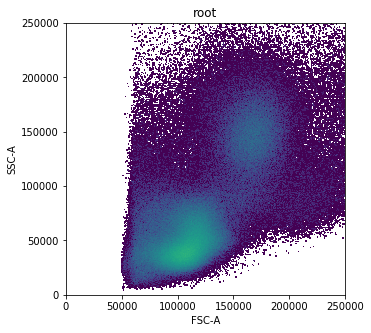

In [8]:
hc1.plotting.plot_population('root', 'FSC-A', 'SSC-A')

I will first apply a preprocessing gate that just removes artifacts in the extremes of the plot. This a measure that should be taken before all automated gating. It prevents high density regions of debris from disrupting the gating algorithm.

In [9]:
child_populations = ChildPopulationCollection('geom')

In [10]:
child_populations.add_population('cells', definition='+')
child_populations.add_population('debris', definition='-')

In [11]:
gate_definition = dict(x='FSC-A', y='SSC-A')
hc1.create_gate(gate_name='debris_gate', parent='root', class_='Static', method='border_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

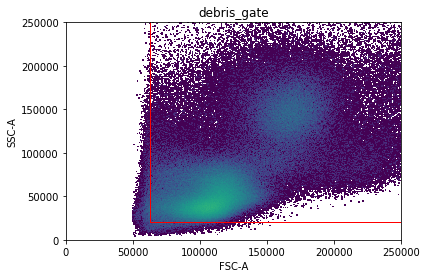

In [12]:
hc1.apply('debris_gate')

<h3>Manual Gate<\h3>

In [13]:
child_populations = ChildPopulationCollection('geom')

In [14]:
child_populations.add_population('manual_lymphocytes', definition='+')
child_populations.add_population('manual_lymphocytes_NEG', definition='-')

In [15]:
gate_definition = dict(x='FSC-A', y='SSC-A', centroid=(110000, 45000), width=100000, height=70000, angle=30)
hc1.create_gate(gate_name='manual_lymphocytes', parent='cells', class_='Static', method='ellipse_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

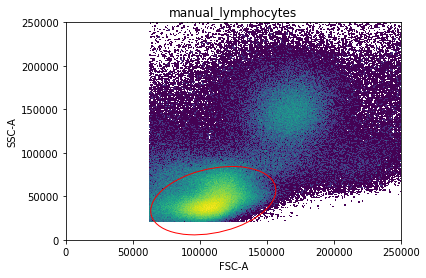

In [16]:
hc1.apply('manual_lymphocytes')

<h3>Mixture Model</h3>

In [15]:
child_populations = ChildPopulationCollection('geom')

In [16]:
child_populations.add_population('gmm_lymphocytes', definition='+')
child_populations.add_population('gmm_lymphocytes_NEG', definition='-')

In [17]:
pre_filter = dict(xmin=50000, xmax=200000, ymin=0, ymax=150000)
gate_definition = dict(x='FSC-A', y='SSC-A', target=(70000, 40000), k=3, rect_filter=pre_filter,
                      conf=0.99)
hc1.create_gate(gate_name='gmm_lymphocytes', parent='cells', class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)

True

sample_id           method  f1_score  accuracy  precision    recall    time
0       hc1  gmm_lymphocytes   0.92786  0.900831   0.997905  0.867004  6.1157

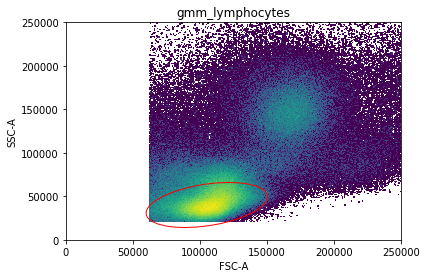

In [18]:
audited_apply(hc1, 'gmm_lymphocytes', 'manual_lymphocytes')

<h3>DBSCAN</h3>

In [19]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('dbscan_lymphocytes', target=(70000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, distance_nn=5000, frac=0.2,nn=10)
hc1.create_gate(gate_name='dbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='dbscan', kwargs=gate_definition, child_populations=child_populations)

True

sample_id              method  f1_score  accuracy  precision    recall  \
0       hc1     gmm_lymphocytes   0.92786  0.900831   0.997905  0.867004   
1       hc1  dbscan_lymphocytes   0.98565  0.978874   0.984963  0.986338   

        time  
0   6.115700  
1  13.159312

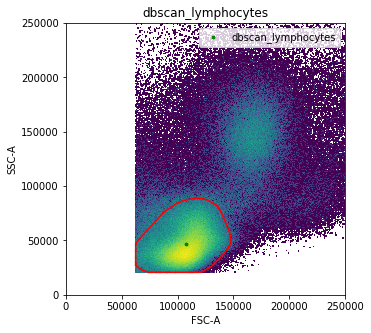

In [20]:
audited_apply(hc1, 'dbscan_lymphocytes', 'manual_lymphocytes')

<h3>HDBSCAN</h3>

In [21]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('hdbscan_lymphocytes', target=(70000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, frac=0.2)
hc1.create_gate(gate_name='hdbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='hdbscan', kwargs=gate_definition, child_populations=child_populations)

True

sample_id               method  f1_score  accuracy  precision    recall  \
0       hc1      gmm_lymphocytes  0.927860  0.900831   0.997905  0.867004   
1       hc1   dbscan_lymphocytes  0.985650  0.978874   0.984963  0.986338   
2       hc1  hdbscan_lymphocytes  0.966983  0.949970   0.939622  0.995985   

         time  
0    6.115700  
1   13.159312  
2  468.238852

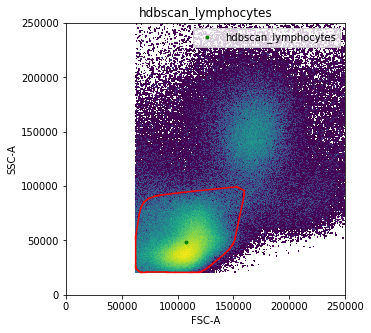

In [22]:
audited_apply(hc1, 'hdbscan_lymphocytes', 'manual_lymphocytes')

<h3>2D Density Threshold</h3>

In [17]:
child_populations = ChildPopulationCollection('threshold_2d')
child_populations.add_population('dens2d_lymphocytes', definition='--')
child_populations.add_population('dens2d_lymphocytes_NEG', definition=['++', '+-', '-+'])
gate_definition = dict(x='FSC-A', y='SSC-A', kde_bw=0.1)
hc1.create_gate(gate_name='dens2d_lymphocytes', parent='cells', class_='DensityThreshold', 
                 method='gate_2d', kwargs=gate_definition, child_populations=child_populations)

True

sample_id               method  f1_score  accuracy  precision    recall  \
0       hc1      gmm_lymphocytes  0.927860  0.900831   0.997905  0.867004   
1       hc1   dbscan_lymphocytes  0.985650  0.978874   0.984963  0.986338   
2       hc1  hdbscan_lymphocytes  0.966983  0.949970   0.939622  0.995985   
3       hc1   dens2d_lymphocytes  0.221310  0.355091   0.989539  0.124587   

         time  
0    6.115700  
1   13.159312  
2  468.238852  
3    3.719155

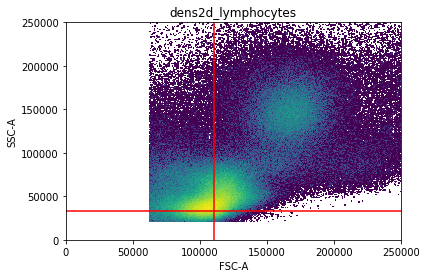

In [18]:
audited_apply(hc1, 'dens2d_lymphocytes', 'manual_lymphocytes')

In [21]:
pd.DataFrame(gating_performance).to_csv('algo_performance.csv', index=False)

<h2>HC4</h2>

In [7]:
hc = Gating(exp, 'hc4')

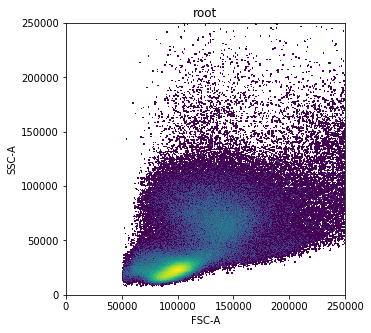

In [8]:
hc.plotting.plot_population('root', 'FSC-A', 'SSC-A')

I will first apply a preprocessing gate that just removes artifacts in the extremes of the plot. This a measure that should be taken before all automated gating. It prevents high density regions of debris from disrupting the gating algorithm.

In [9]:
child_populations = ChildPopulationCollection('geom')

In [10]:
child_populations.add_population('cells', definition='+')
child_populations.add_population('debris', definition='-')

In [11]:
gate_definition = dict(x='FSC-A', y='SSC-A')
hc.create_gate(gate_name='debris_gate', parent='root', class_='Static', method='border_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

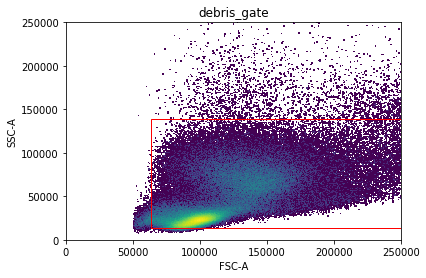

In [12]:
hc.apply('debris_gate')

<h3>Manual Gate<\h3>

In [13]:
child_populations = ChildPopulationCollection('geom')

In [14]:
child_populations.add_population('manual_lymphocytes', definition='+')
child_populations.add_population('manual_lymphocytes_NEG', definition='-')

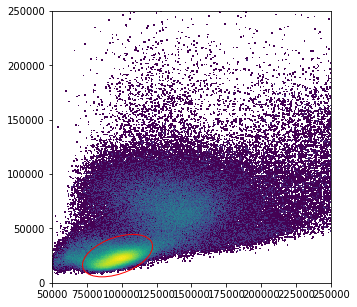

In [15]:
visualise_manual_ellipse(hc.get_population_df('root'), 'FSC-A', 'SSC-A', centroid=(97000, 25000), width=55000, height=32000, angle=30,
                        xlim=(50000, 250000), ylim=(0, 250000))

In [16]:
gate_definition = dict(x='FSC-A', y='SSC-A', centroid=(97000, 25000), width=55000, height=32000, angle=30)
hc.create_gate(gate_name='manual_lymphocytes', parent='cells', class_='Static', method='ellipse_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

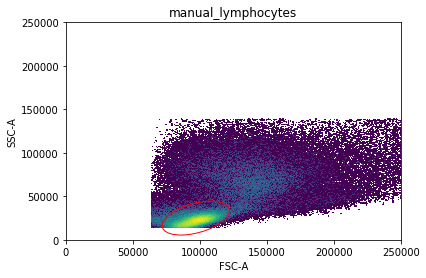

In [17]:
hc.apply('manual_lymphocytes')

<h3>Mixture Model</h3>

In [18]:
child_populations = ChildPopulationCollection('geom')

In [19]:
child_populations.add_population('gmm_lymphocytes', definition='+')
child_populations.add_population('gmm_lymphocytes_NEG', definition='-')

In [20]:
pre_filter = dict(xmin=50000, xmax=200000, ymin=0, ymax=150000)
gate_definition = dict(x='FSC-A', y='SSC-A', target=(70000, 40000), k=3, rect_filter=pre_filter,
                      conf=0.99)
hc.create_gate(gate_name='gmm_lymphocytes', parent='cells', class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)

True

sample_id               method  f1_score  accuracy  precision    recall  \
0       hc1      gmm_lymphocytes  0.927860  0.900831   0.997905  0.867004   
1       hc1   dbscan_lymphocytes  0.985650  0.978874   0.984963  0.986338   
2       hc1  hdbscan_lymphocytes  0.966983  0.949970   0.939622  0.995985   
3       hc1   dens2d_lymphocytes  0.221310  0.355091   0.989539  0.124587   
4       hc4      gmm_lymphocytes  0.974289  0.961781   0.950037  0.999811   

         time  
0    6.115700  
1   13.159312  
2  468.238852  
3    3.719155  
4    4.871430

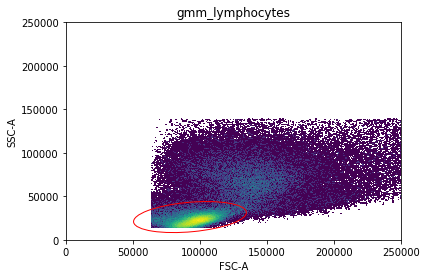

In [21]:
audited_apply(hc, 'gmm_lymphocytes', 'manual_lymphocytes')

<h3>DBSCAN</h3>

In [22]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('dbscan_lymphocytes', target=(75000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, distance_nn=5000, frac=0.2,nn=10)
hc.create_gate(gate_name='dbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='dbscan', kwargs=gate_definition, child_populations=child_populations)

True

sample_id               method  f1_score  accuracy  precision    recall  \
0       hc1      gmm_lymphocytes  0.927860  0.900831   0.997905  0.867004   
1       hc1   dbscan_lymphocytes  0.985650  0.978874   0.984963  0.986338   
2       hc1  hdbscan_lymphocytes  0.966983  0.949970   0.939622  0.995985   
3       hc1   dens2d_lymphocytes  0.221310  0.355091   0.989539  0.124587   
4       hc4      gmm_lymphocytes  0.974289  0.961781   0.950037  0.999811   
5       hc4   dbscan_lymphocytes  0.980299  0.970954   0.963404  0.997798   

         time  
0    6.115700  
1   13.159312  
2  468.238852  
3    3.719155  
4    4.871430  
5   11.819951

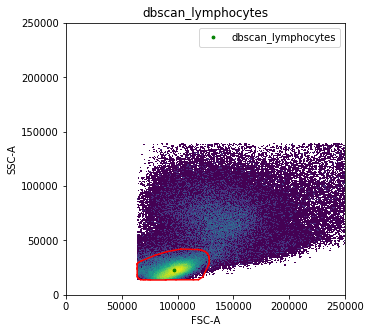

In [23]:
audited_apply(hc, 'dbscan_lymphocytes', 'manual_lymphocytes')

<h3>HDBSCAN</h3>

In [24]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('hdbscan_lymphocytes', target=(70000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, frac=0.2)
hc.create_gate(gate_name='hdbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='hdbscan', kwargs=gate_definition, child_populations=child_populations)

True

sample_id               method  f1_score  accuracy  precision    recall  \
0       hc1      gmm_lymphocytes  0.927860  0.900831   0.997905  0.867004   
1       hc1   dbscan_lymphocytes  0.985650  0.978874   0.984963  0.986338   
2       hc1  hdbscan_lymphocytes  0.966983  0.949970   0.939622  0.995985   
3       hc1   dens2d_lymphocytes  0.221310  0.355091   0.989539  0.124587   
4       hc4      gmm_lymphocytes  0.974289  0.961781   0.950037  0.999811   
5       hc4   dbscan_lymphocytes  0.980299  0.970954   0.963404  0.997798   
6       hc4  hdbscan_lymphocytes  0.976521  0.965339   0.958532  0.995198   

         time  
0    6.115700  
1   13.159312  
2  468.238852  
3    3.719155  
4    4.871430  
5   11.819951  
6  231.729461

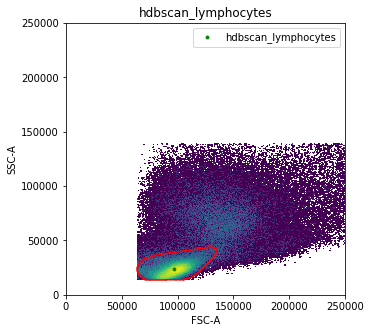

In [25]:
audited_apply(hc, 'hdbscan_lymphocytes', 'manual_lymphocytes')

<h3>2D Density Threshold</h3>

In [26]:
child_populations = ChildPopulationCollection('threshold_2d')
child_populations.add_population('dens2d_lymphocytes', definition='--')
child_populations.add_population('dens2d_lymphocytes_NEG', definition=['++', '+-', '-+'])
gate_definition = dict(x='FSC-A', y='SSC-A', kde_bw=0.1)
hc.create_gate(gate_name='dens2d_lymphocytes', parent='cells', class_='DensityThreshold', 
                 method='gate_2d', kwargs=gate_definition, child_populations=child_populations)

True

sample_id               method  f1_score  accuracy  precision    recall  \
0       hc1      gmm_lymphocytes  0.927860  0.900831   0.997905  0.867004   
1       hc1   dbscan_lymphocytes  0.985650  0.978874   0.984963  0.986338   
2       hc1  hdbscan_lymphocytes  0.966983  0.949970   0.939622  0.995985   
3       hc1   dens2d_lymphocytes  0.221310  0.355091   0.989539  0.124587   
4       hc4      gmm_lymphocytes  0.974289  0.961781   0.950037  0.999811   
5       hc4   dbscan_lymphocytes  0.980299  0.970954   0.963404  0.997798   
6       hc4  hdbscan_lymphocytes  0.976521  0.965339   0.958532  0.995198   
7       hc4   dens2d_lymphocytes  0.544030  0.541808   0.974107  0.377403   

         time  
0    6.115700  
1   13.159312  
2  468.238852  
3    3.719155  
4    4.871430  
5   11.819951  
6  231.729461  
7    1.653266

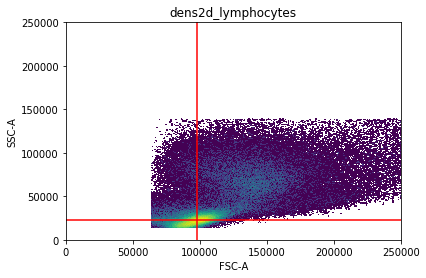

In [27]:
audited_apply(hc, 'dens2d_lymphocytes', 'manual_lymphocytes')

In [43]:
pd.DataFrame(gating_performance).to_csv('algo_performance.csv', index=False)

<h2>HC7</h2>

In [75]:
pd.DataFrame(gating_performance).to_csv('algo_performance.csv', index=False)

In [52]:
hc = Gating(exp, 'hc7')

sample_id               method  f1_score  accuracy  precision    recall  \
0        hc1      gmm_lymphocytes  0.927860  0.900831   0.997905  0.867004   
1        hc1   dbscan_lymphocytes  0.985650  0.978874   0.984963  0.986338   
2        hc1  hdbscan_lymphocytes  0.966983  0.949970   0.939622  0.995985   
3        hc1   dens2d_lymphocytes  0.221310  0.355091   0.989539  0.124587   
4        hc4      gmm_lymphocytes  0.974289  0.961781   0.950037  0.999811   
5        hc4   dbscan_lymphocytes  0.980299  0.970954   0.963404  0.997798   
6        hc4  hdbscan_lymphocytes  0.976521  0.965339   0.958532  0.995198   
7        hc4   dens2d_lymphocytes  0.544030  0.541808   0.974107  0.377403   
8        hc5      gmm_lymphocytes  0.978192  0.970679   0.986523  0.970000   
9        hc5   dbscan_lymphocytes  0.979867  0.972223   0.963234  0.997084   
10       hc5  hdbscan_lymphocytes  0.976385  0.967337   0.957475  0.996057   
11       hc5   dens2d_lymphocytes  0.361958  0.470491   0.988272  0.221551   
12       hc7      gmm_lymphocytes  0.845585  0.833315   0.809681  0.884821   
13       hc7   dbscan_lymphocytes  0.910492  0.898710   0.836542  0.998783   
14       hc7  hdbscan_lymphocytes  0.899625  0.884908   0.817605  0.999936   
15       hc7   dens2d_lymphocytes  0.460371  0.614583   0.828525  0.318739   

          time  
0     6.115700  
1    13.159312  
2   468.238852  
3     3.719155  
4     4.871430  
5    11.819951  
6   231.729461  
7     1.653266  
8     2.633845  
9    11.912364  
10  212.598680  
11    1.538740  
12    2.929482  
13    7.924105  
14  273.524955  
15    2.300163

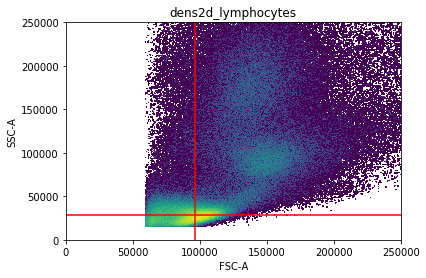

In [74]:
audited_apply(hc, 'dens2d_lymphocytes', 'manual_lymphocytes')

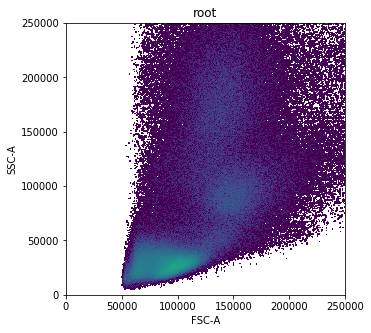

In [53]:
hc.plotting.plot_population('root', 'FSC-A', 'SSC-A')

In [73]:
child_populations = ChildPopulationCollection('threshold_2d')
child_populations.add_population('dens2d_lymphocytes', definition='--')
child_populations.add_population('dens2d_lymphocytes_NEG', definition=['++', '+-', '-+'])
gate_definition = dict(x='FSC-A', y='SSC-A', kde_bw=0.1)
hc.create_gate(gate_name='dens2d_lymphocytes', parent='cells', class_='DensityThreshold', 
                 method='gate_2d', kwargs=gate_definition, child_populations=child_populations)

True

I will first apply a preprocessing gate that just removes artifacts in the extremes of the plot. This a measure that should be taken before all automated gating. It prevents high density regions of debris from disrupting the gating algorithm.

<h3>2D Density Threshold</h3>

In [54]:
child_populations = ChildPopulationCollection('geom')

sample_id               method  f1_score  accuracy  precision    recall  \
0        hc1      gmm_lymphocytes  0.927860  0.900831   0.997905  0.867004   
1        hc1   dbscan_lymphocytes  0.985650  0.978874   0.984963  0.986338   
2        hc1  hdbscan_lymphocytes  0.966983  0.949970   0.939622  0.995985   
3        hc1   dens2d_lymphocytes  0.221310  0.355091   0.989539  0.124587   
4        hc4      gmm_lymphocytes  0.974289  0.961781   0.950037  0.999811   
5        hc4   dbscan_lymphocytes  0.980299  0.970954   0.963404  0.997798   
6        hc4  hdbscan_lymphocytes  0.976521  0.965339   0.958532  0.995198   
7        hc4   dens2d_lymphocytes  0.544030  0.541808   0.974107  0.377403   
8        hc5      gmm_lymphocytes  0.978192  0.970679   0.986523  0.970000   
9        hc5   dbscan_lymphocytes  0.979867  0.972223   0.963234  0.997084   
10       hc5  hdbscan_lymphocytes  0.976385  0.967337   0.957475  0.996057   
11       hc5   dens2d_lymphocytes  0.361958  0.470491   0.988272  0.221551   
12       hc7      gmm_lymphocytes  0.845585  0.833315   0.809681  0.884821   
13       hc7   dbscan_lymphocytes  0.910492  0.898710   0.836542  0.998783   
14       hc7  hdbscan_lymphocytes  0.899625  0.884908   0.817605  0.999936   

          time  
0     6.115700  
1    13.159312  
2   468.238852  
3     3.719155  
4     4.871430  
5    11.819951  
6   231.729461  
7     1.653266  
8     2.633845  
9    11.912364  
10  212.598680  
11    1.538740  
12    2.929482  
13    7.924105  
14  273.524955

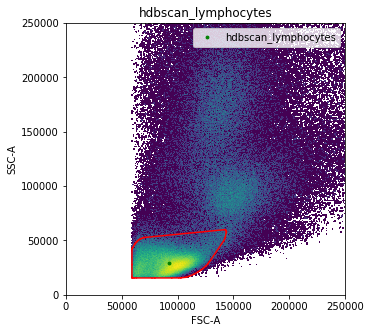

In [72]:
audited_apply(hc, 'hdbscan_lymphocytes', 'manual_lymphocytes')

In [55]:
child_populations.add_population('cells', definition='+')
child_populations.add_population('debris', definition='-')

In [71]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('hdbscan_lymphocytes', target=(70000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, frac=0.2)
hc.create_gate(gate_name='hdbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='hdbscan', kwargs=gate_definition, child_populations=child_populations)

True

In [56]:
gate_definition = dict(x='FSC-A', y='SSC-A')
hc.create_gate(gate_name='debris_gate', parent='root', class_='Static', method='border_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

<h3>HDBSCAN</h3>

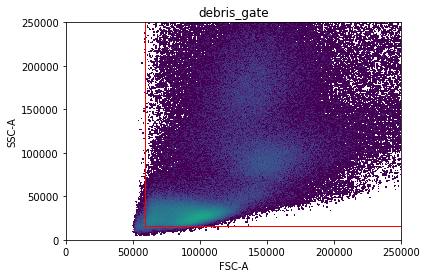

In [57]:
hc.apply('debris_gate')

sample_id               method  f1_score  accuracy  precision    recall  \
0        hc1      gmm_lymphocytes  0.927860  0.900831   0.997905  0.867004   
1        hc1   dbscan_lymphocytes  0.985650  0.978874   0.984963  0.986338   
2        hc1  hdbscan_lymphocytes  0.966983  0.949970   0.939622  0.995985   
3        hc1   dens2d_lymphocytes  0.221310  0.355091   0.989539  0.124587   
4        hc4      gmm_lymphocytes  0.974289  0.961781   0.950037  0.999811   
5        hc4   dbscan_lymphocytes  0.980299  0.970954   0.963404  0.997798   
6        hc4  hdbscan_lymphocytes  0.976521  0.965339   0.958532  0.995198   
7        hc4   dens2d_lymphocytes  0.544030  0.541808   0.974107  0.377403   
8        hc5      gmm_lymphocytes  0.978192  0.970679   0.986523  0.970000   
9        hc5   dbscan_lymphocytes  0.979867  0.972223   0.963234  0.997084   
10       hc5  hdbscan_lymphocytes  0.976385  0.967337   0.957475  0.996057   
11       hc5   dens2d_lymphocytes  0.361958  0.470491   0.988272  0.221551   
12       hc7      gmm_lymphocytes  0.845585  0.833315   0.809681  0.884821   
13       hc7   dbscan_lymphocytes  0.910492  0.898710   0.836542  0.998783   

          time  
0     6.115700  
1    13.159312  
2   468.238852  
3     3.719155  
4     4.871430  
5    11.819951  
6   231.729461  
7     1.653266  
8     2.633845  
9    11.912364  
10  212.598680  
11    1.538740  
12    2.929482  
13    7.924105

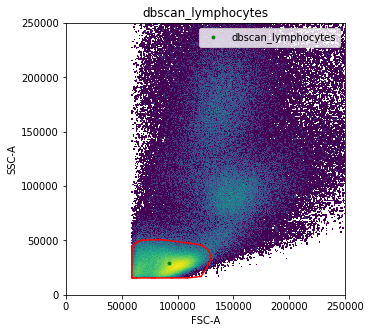

In [70]:
audited_apply(hc, 'dbscan_lymphocytes', 'manual_lymphocytes')

<h3>Manual Gate<\h3>

In [69]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('dbscan_lymphocytes', target=(75000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, distance_nn=5000, frac=0.2,nn=10)
hc.create_gate(gate_name='dbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='dbscan', kwargs=gate_definition, child_populations=child_populations)

True

In [58]:
child_populations = ChildPopulationCollection('geom')

<h3>DBSCAN</h3>

In [59]:
child_populations.add_population('manual_lymphocytes', definition='+')
child_populations.add_population('manual_lymphocytes_NEG', definition='-')

sample_id               method  f1_score  accuracy  precision    recall  \
0        hc1      gmm_lymphocytes  0.927860  0.900831   0.997905  0.867004   
1        hc1   dbscan_lymphocytes  0.985650  0.978874   0.984963  0.986338   
2        hc1  hdbscan_lymphocytes  0.966983  0.949970   0.939622  0.995985   
3        hc1   dens2d_lymphocytes  0.221310  0.355091   0.989539  0.124587   
4        hc4      gmm_lymphocytes  0.974289  0.961781   0.950037  0.999811   
5        hc4   dbscan_lymphocytes  0.980299  0.970954   0.963404  0.997798   
6        hc4  hdbscan_lymphocytes  0.976521  0.965339   0.958532  0.995198   
7        hc4   dens2d_lymphocytes  0.544030  0.541808   0.974107  0.377403   
8        hc5      gmm_lymphocytes  0.978192  0.970679   0.986523  0.970000   
9        hc5   dbscan_lymphocytes  0.979867  0.972223   0.963234  0.997084   
10       hc5  hdbscan_lymphocytes  0.976385  0.967337   0.957475  0.996057   
11       hc5   dens2d_lymphocytes  0.361958  0.470491   0.988272  0.221551   
12       hc7      gmm_lymphocytes  0.845585  0.833315   0.809681  0.884821   

          time  
0     6.115700  
1    13.159312  
2   468.238852  
3     3.719155  
4     4.871430  
5    11.819951  
6   231.729461  
7     1.653266  
8     2.633845  
9    11.912364  
10  212.598680  
11    1.538740  
12    2.929482

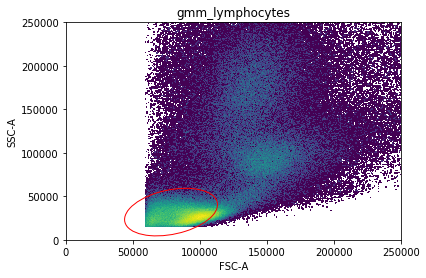

In [68]:
audited_apply(hc, 'gmm_lymphocytes', 'manual_lymphocytes')

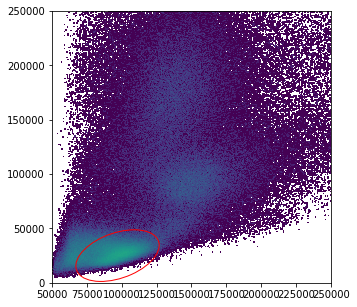

In [62]:
visualise_manual_ellipse(hc.get_population_df('root'), 'FSC-A', 'SSC-A', centroid=(97000, 25000), width=65000, height=40000, angle=30,
                        xlim=(50000, 250000), ylim=(0, 250000))

In [67]:
pre_filter = dict(xmin=50000, xmax=200000, ymin=0, ymax=150000)
gate_definition = dict(x='FSC-A', y='SSC-A', target=(70000, 40000), k=3, rect_filter=pre_filter,
                      conf=0.99)
hc.create_gate(gate_name='gmm_lymphocytes', parent='cells', class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)

True

In [63]:
gate_definition = dict(x='FSC-A', y='SSC-A', centroid=(97000, 25000), width=65000, height=40000, angle=30)
hc.create_gate(gate_name='manual_lymphocytes', parent='cells', class_='Static', method='ellipse_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

In [66]:
child_populations.add_population('gmm_lymphocytes', definition='+')
child_populations.add_population('gmm_lymphocytes_NEG', definition='-')

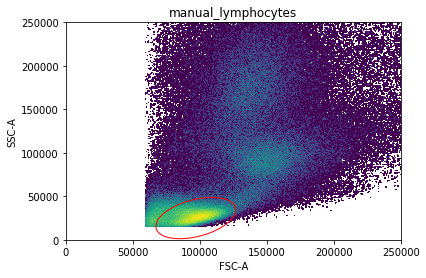

In [64]:
hc.apply('manual_lymphocytes')

In [65]:
child_populations = ChildPopulationCollection('geom')

<h2>HC5</h2>

In [28]:
hc = Gating(exp, 'hc5')

In [50]:
pd.DataFrame(gating_performance).to_csv('algo_performance.csv', index=False)

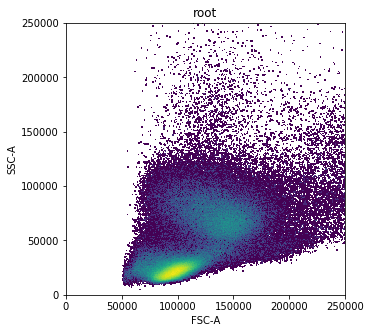

In [29]:
hc.plotting.plot_population('root', 'FSC-A', 'SSC-A')

sample_id               method  f1_score  accuracy  precision    recall  \
0        hc1      gmm_lymphocytes  0.927860  0.900831   0.997905  0.867004   
1        hc1   dbscan_lymphocytes  0.985650  0.978874   0.984963  0.986338   
2        hc1  hdbscan_lymphocytes  0.966983  0.949970   0.939622  0.995985   
3        hc1   dens2d_lymphocytes  0.221310  0.355091   0.989539  0.124587   
4        hc4      gmm_lymphocytes  0.974289  0.961781   0.950037  0.999811   
5        hc4   dbscan_lymphocytes  0.980299  0.970954   0.963404  0.997798   
6        hc4  hdbscan_lymphocytes  0.976521  0.965339   0.958532  0.995198   
7        hc4   dens2d_lymphocytes  0.544030  0.541808   0.974107  0.377403   
8        hc5      gmm_lymphocytes  0.978192  0.970679   0.986523  0.970000   
9        hc5   dbscan_lymphocytes  0.979867  0.972223   0.963234  0.997084   
10       hc5  hdbscan_lymphocytes  0.976385  0.967337   0.957475  0.996057   
11       hc5   dens2d_lymphocytes  0.361958  0.470491   0.988272  0.221551   

          time  
0     6.115700  
1    13.159312  
2   468.238852  
3     3.719155  
4     4.871430  
5    11.819951  
6   231.729461  
7     1.653266  
8     2.633845  
9    11.912364  
10  212.598680  
11    1.538740

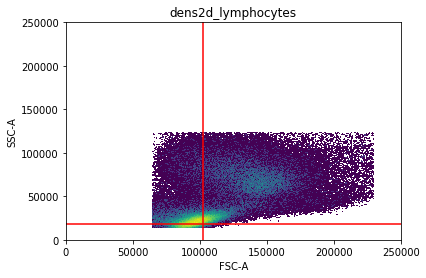

In [49]:
audited_apply(hc, 'dens2d_lymphocytes', 'manual_lymphocytes')

I will first apply a preprocessing gate that just removes artifacts in the extremes of the plot. This a measure that should be taken before all automated gating. It prevents high density regions of debris from disrupting the gating algorithm.

In [48]:
child_populations = ChildPopulationCollection('threshold_2d')
child_populations.add_population('dens2d_lymphocytes', definition='--')
child_populations.add_population('dens2d_lymphocytes_NEG', definition=['++', '+-', '-+'])
gate_definition = dict(x='FSC-A', y='SSC-A', kde_bw=0.1)
hc.create_gate(gate_name='dens2d_lymphocytes', parent='cells', class_='DensityThreshold', 
                 method='gate_2d', kwargs=gate_definition, child_populations=child_populations)

True

In [30]:
child_populations = ChildPopulationCollection('geom')

<h3>2D Density Threshold</h3>

In [31]:
child_populations.add_population('cells', definition='+')
child_populations.add_population('debris', definition='-')

sample_id               method  f1_score  accuracy  precision    recall  \
0        hc1      gmm_lymphocytes  0.927860  0.900831   0.997905  0.867004   
1        hc1   dbscan_lymphocytes  0.985650  0.978874   0.984963  0.986338   
2        hc1  hdbscan_lymphocytes  0.966983  0.949970   0.939622  0.995985   
3        hc1   dens2d_lymphocytes  0.221310  0.355091   0.989539  0.124587   
4        hc4      gmm_lymphocytes  0.974289  0.961781   0.950037  0.999811   
5        hc4   dbscan_lymphocytes  0.980299  0.970954   0.963404  0.997798   
6        hc4  hdbscan_lymphocytes  0.976521  0.965339   0.958532  0.995198   
7        hc4   dens2d_lymphocytes  0.544030  0.541808   0.974107  0.377403   
8        hc5      gmm_lymphocytes  0.978192  0.970679   0.986523  0.970000   
9        hc5   dbscan_lymphocytes  0.979867  0.972223   0.963234  0.997084   
10       hc5  hdbscan_lymphocytes  0.976385  0.967337   0.957475  0.996057   

          time  
0     6.115700  
1    13.159312  
2   468.238852  
3     3.719155  
4     4.871430  
5    11.819951  
6   231.729461  
7     1.653266  
8     2.633845  
9    11.912364  
10  212.598680

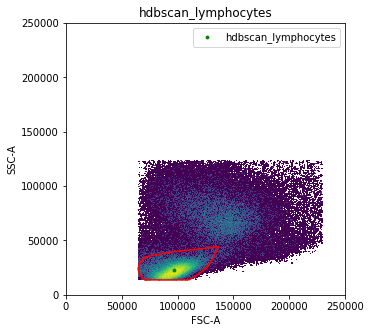

In [47]:
audited_apply(hc, 'hdbscan_lymphocytes', 'manual_lymphocytes')

In [32]:
gate_definition = dict(x='FSC-A', y='SSC-A')
hc.create_gate(gate_name='debris_gate', parent='root', class_='Static', method='border_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

In [46]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('hdbscan_lymphocytes', target=(70000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, frac=0.2)
hc.create_gate(gate_name='hdbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='hdbscan', kwargs=gate_definition, child_populations=child_populations)

True

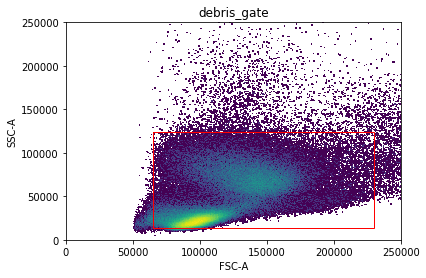

In [33]:
hc.apply('debris_gate')

<h3>HDBSCAN</h3>

<h3>Manual Gate<\h3>

Expected 1 populations, identified 2; {0, 1, -1}


sample_id               method  f1_score  accuracy  precision    recall  \
0       hc1      gmm_lymphocytes  0.927860  0.900831   0.997905  0.867004   
1       hc1   dbscan_lymphocytes  0.985650  0.978874   0.984963  0.986338   
2       hc1  hdbscan_lymphocytes  0.966983  0.949970   0.939622  0.995985   
3       hc1   dens2d_lymphocytes  0.221310  0.355091   0.989539  0.124587   
4       hc4      gmm_lymphocytes  0.974289  0.961781   0.950037  0.999811   
5       hc4   dbscan_lymphocytes  0.980299  0.970954   0.963404  0.997798   
6       hc4  hdbscan_lymphocytes  0.976521  0.965339   0.958532  0.995198   
7       hc4   dens2d_lymphocytes  0.544030  0.541808   0.974107  0.377403   
8       hc5      gmm_lymphocytes  0.978192  0.970679   0.986523  0.970000   
9       hc5   dbscan_lymphocytes  0.979867  0.972223   0.963234  0.997084   

         time  
0    6.115700  
1   13.159312  
2  468.238852  
3    3.719155  
4    4.871430  
5   11.819951  
6  231.729461  
7    1.653266  
8    2.633845  
9   11.912364

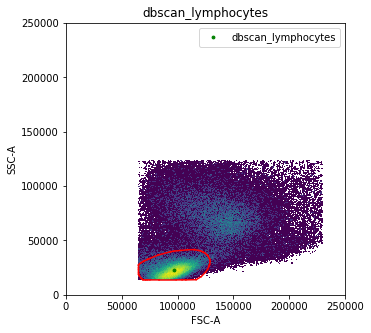

In [45]:
audited_apply(hc, 'dbscan_lymphocytes', 'manual_lymphocytes')

In [34]:
child_populations = ChildPopulationCollection('geom')

In [44]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('dbscan_lymphocytes', target=(75000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, distance_nn=5000, frac=0.2,nn=10)
hc.create_gate(gate_name='dbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='dbscan', kwargs=gate_definition, child_populations=child_populations)

True

In [35]:
child_populations.add_population('manual_lymphocytes', definition='+')
child_populations.add_population('manual_lymphocytes_NEG', definition='-')

<h3>DBSCAN</h3>

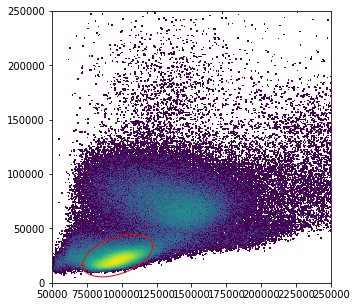

In [36]:
visualise_manual_ellipse(hc.get_population_df('root'), 'FSC-A', 'SSC-A', centroid=(97000, 25000), width=55000, height=32000, angle=30,
                        xlim=(50000, 250000), ylim=(0, 250000))

sample_id               method  f1_score  accuracy  precision    recall  \
0       hc1      gmm_lymphocytes  0.927860  0.900831   0.997905  0.867004   
1       hc1   dbscan_lymphocytes  0.985650  0.978874   0.984963  0.986338   
2       hc1  hdbscan_lymphocytes  0.966983  0.949970   0.939622  0.995985   
3       hc1   dens2d_lymphocytes  0.221310  0.355091   0.989539  0.124587   
4       hc4      gmm_lymphocytes  0.974289  0.961781   0.950037  0.999811   
5       hc4   dbscan_lymphocytes  0.980299  0.970954   0.963404  0.997798   
6       hc4  hdbscan_lymphocytes  0.976521  0.965339   0.958532  0.995198   
7       hc4   dens2d_lymphocytes  0.544030  0.541808   0.974107  0.377403   
8       hc5      gmm_lymphocytes  0.978192  0.970679   0.986523  0.970000   

         time  
0    6.115700  
1   13.159312  
2  468.238852  
3    3.719155  
4    4.871430  
5   11.819951  
6  231.729461  
7    1.653266  
8    2.633845

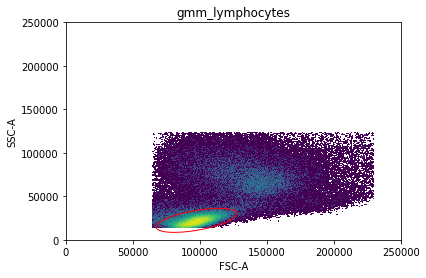

In [42]:
audited_apply(hc, 'gmm_lymphocytes', 'manual_lymphocytes')

In [37]:
gate_definition = dict(x='FSC-A', y='SSC-A', centroid=(97000, 25000), width=55000, height=32000, angle=30)
hc.create_gate(gate_name='manual_lymphocytes', parent='cells', class_='Static', method='ellipse_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

In [41]:
pre_filter = dict(xmin=50000, xmax=200000, ymin=0, ymax=150000)
gate_definition = dict(x='FSC-A', y='SSC-A', target=(70000, 40000), k=3, rect_filter=pre_filter,
                      conf=0.99)
hc.create_gate(gate_name='gmm_lymphocytes', parent='cells', class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)

True

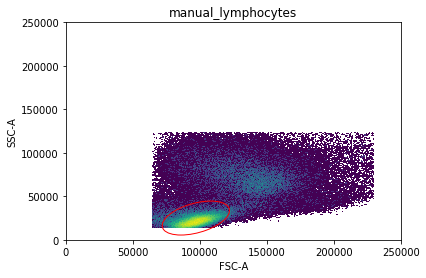

In [38]:
hc.apply('manual_lymphocytes')

In [40]:
child_populations.add_population('gmm_lymphocytes', definition='+')
child_populations.add_population('gmm_lymphocytes_NEG', definition='-')

<h3>Mixture Model</h3>

<h2>HC9</h2>

In [39]:
child_populations = ChildPopulationCollection('geom')

In [77]:
hc = Gating(exp, 'hc9')

In [102]:
pd.DataFrame(gating_performance).to_csv('algo_performance.csv', index=False)

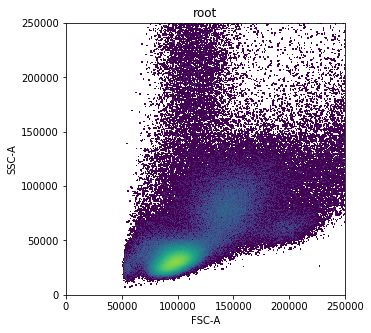

In [78]:
hc.plotting.plot_population('root', 'FSC-A', 'SSC-A')

sample_id               method  f1_score  accuracy  precision    recall  \
0        hc1      gmm_lymphocytes  0.927860  0.900831   0.997905  0.867004   
1        hc1   dbscan_lymphocytes  0.985650  0.978874   0.984963  0.986338   
2        hc1  hdbscan_lymphocytes  0.966983  0.949970   0.939622  0.995985   
3        hc1   dens2d_lymphocytes  0.221310  0.355091   0.989539  0.124587   
4        hc4      gmm_lymphocytes  0.974289  0.961781   0.950037  0.999811   
5        hc4   dbscan_lymphocytes  0.980299  0.970954   0.963404  0.997798   
6        hc4  hdbscan_lymphocytes  0.976521  0.965339   0.958532  0.995198   
7        hc4   dens2d_lymphocytes  0.544030  0.541808   0.974107  0.377403   
8        hc5      gmm_lymphocytes  0.978192  0.970679   0.986523  0.970000   
9        hc5   dbscan_lymphocytes  0.979867  0.972223   0.963234  0.997084   
10       hc5  hdbscan_lymphocytes  0.976385  0.967337   0.957475  0.996057   
11       hc5   dens2d_lymphocytes  0.361958  0.470491   0.988272  0.221551   
12       hc7      gmm_lymphocytes  0.845585  0.833315   0.809681  0.884821   
13       hc7   dbscan_lymphocytes  0.910492  0.898710   0.836542  0.998783   
14       hc7  hdbscan_lymphocytes  0.899625  0.884908   0.817605  0.999936   
15       hc7   dens2d_lymphocytes  0.460371  0.614583   0.828525  0.318739   
16       hc9      gmm_lymphocytes  0.988764  0.981209   1.000000  0.977778   
17       hc9   dbscan_lymphocytes  0.990936  0.984532   0.982036  0.999999   
18       hc9  hdbscan_lymphocytes  0.986995  0.977723   0.974545  0.999768   
19       hc9   dens2d_lymphocytes  0.440241  0.393087   0.999972  0.282251   

          time  
0     6.115700  
1    13.159312  
2   468.238852  
3     3.719155  
4     4.871430  
5    11.819951  
6   231.729461  
7     1.653266  
8     2.633845  
9    11.912364  
10  212.598680  
11    1.538740  
12    2.929482  
13    7.924105  
14  273.524955  
15    2.300163  
16    5.527719  
17   76.826609  
18  469.947415  
19    4.030855

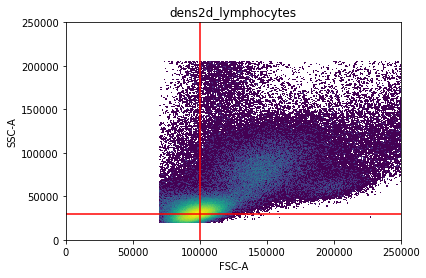

In [100]:
audited_apply(hc, 'dens2d_lymphocytes', 'manual_lymphocytes')

I will first apply a preprocessing gate that just removes artifacts in the extremes of the plot. This a measure that should be taken before all automated gating. It prevents high density regions of debris from disrupting the gating algorithm.

In [99]:
child_populations = ChildPopulationCollection('threshold_2d')
child_populations.add_population('dens2d_lymphocytes', definition='--')
child_populations.add_population('dens2d_lymphocytes_NEG', definition=['++', '+-', '-+'])
gate_definition = dict(x='FSC-A', y='SSC-A', kde_bw=0.1)
hc.create_gate(gate_name='dens2d_lymphocytes', parent='cells', class_='DensityThreshold', 
                 method='gate_2d', kwargs=gate_definition, child_populations=child_populations)

True

In [79]:
child_populations = ChildPopulationCollection('geom')

<h3>2D Density Threshold</h3>

In [80]:
child_populations.add_population('cells', definition='+')
child_populations.add_population('debris', definition='-')

sample_id               method  f1_score  accuracy  precision    recall  \
0        hc1      gmm_lymphocytes  0.927860  0.900831   0.997905  0.867004   
1        hc1   dbscan_lymphocytes  0.985650  0.978874   0.984963  0.986338   
2        hc1  hdbscan_lymphocytes  0.966983  0.949970   0.939622  0.995985   
3        hc1   dens2d_lymphocytes  0.221310  0.355091   0.989539  0.124587   
4        hc4      gmm_lymphocytes  0.974289  0.961781   0.950037  0.999811   
5        hc4   dbscan_lymphocytes  0.980299  0.970954   0.963404  0.997798   
6        hc4  hdbscan_lymphocytes  0.976521  0.965339   0.958532  0.995198   
7        hc4   dens2d_lymphocytes  0.544030  0.541808   0.974107  0.377403   
8        hc5      gmm_lymphocytes  0.978192  0.970679   0.986523  0.970000   
9        hc5   dbscan_lymphocytes  0.979867  0.972223   0.963234  0.997084   
10       hc5  hdbscan_lymphocytes  0.976385  0.967337   0.957475  0.996057   
11       hc5   dens2d_lymphocytes  0.361958  0.470491   0.988272  0.221551   
12       hc7      gmm_lymphocytes  0.845585  0.833315   0.809681  0.884821   
13       hc7   dbscan_lymphocytes  0.910492  0.898710   0.836542  0.998783   
14       hc7  hdbscan_lymphocytes  0.899625  0.884908   0.817605  0.999936   
15       hc7   dens2d_lymphocytes  0.460371  0.614583   0.828525  0.318739   
16       hc9      gmm_lymphocytes  0.988764  0.981209   1.000000  0.977778   
17       hc9   dbscan_lymphocytes  0.990936  0.984532   0.982036  0.999999   
18       hc9  hdbscan_lymphocytes  0.986995  0.977723   0.974545  0.999768   

          time  
0     6.115700  
1    13.159312  
2   468.238852  
3     3.719155  
4     4.871430  
5    11.819951  
6   231.729461  
7     1.653266  
8     2.633845  
9    11.912364  
10  212.598680  
11    1.538740  
12    2.929482  
13    7.924105  
14  273.524955  
15    2.300163  
16    5.527719  
17   76.826609  
18  469.947415

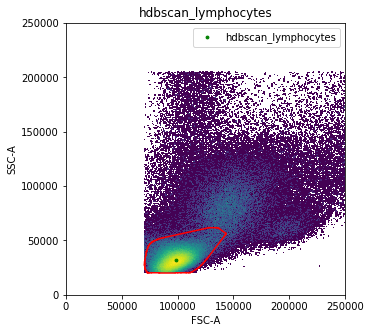

In [98]:
audited_apply(hc, 'hdbscan_lymphocytes', 'manual_lymphocytes')

In [81]:
gate_definition = dict(x='FSC-A', y='SSC-A')
hc.create_gate(gate_name='debris_gate', parent='root', class_='Static', method='border_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

In [97]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('hdbscan_lymphocytes', target=(70000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, frac=0.2)
hc.create_gate(gate_name='hdbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='hdbscan', kwargs=gate_definition, child_populations=child_populations)

True

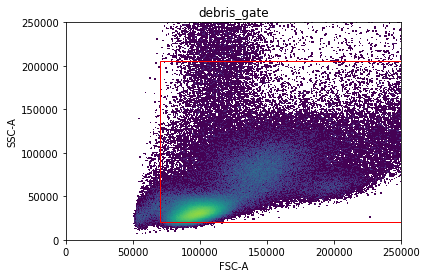

In [82]:
hc.apply('debris_gate')

<h3>HDBSCAN</h3>

<h3>Manual Gate<\h3>

sample_id               method  f1_score  accuracy  precision    recall  \
0        hc1      gmm_lymphocytes  0.927860  0.900831   0.997905  0.867004   
1        hc1   dbscan_lymphocytes  0.985650  0.978874   0.984963  0.986338   
2        hc1  hdbscan_lymphocytes  0.966983  0.949970   0.939622  0.995985   
3        hc1   dens2d_lymphocytes  0.221310  0.355091   0.989539  0.124587   
4        hc4      gmm_lymphocytes  0.974289  0.961781   0.950037  0.999811   
5        hc4   dbscan_lymphocytes  0.980299  0.970954   0.963404  0.997798   
6        hc4  hdbscan_lymphocytes  0.976521  0.965339   0.958532  0.995198   
7        hc4   dens2d_lymphocytes  0.544030  0.541808   0.974107  0.377403   
8        hc5      gmm_lymphocytes  0.978192  0.970679   0.986523  0.970000   
9        hc5   dbscan_lymphocytes  0.979867  0.972223   0.963234  0.997084   
10       hc5  hdbscan_lymphocytes  0.976385  0.967337   0.957475  0.996057   
11       hc5   dens2d_lymphocytes  0.361958  0.470491   0.988272  0.221551   
12       hc7      gmm_lymphocytes  0.845585  0.833315   0.809681  0.884821   
13       hc7   dbscan_lymphocytes  0.910492  0.898710   0.836542  0.998783   
14       hc7  hdbscan_lymphocytes  0.899625  0.884908   0.817605  0.999936   
15       hc7   dens2d_lymphocytes  0.460371  0.614583   0.828525  0.318739   
16       hc9      gmm_lymphocytes  0.988764  0.981209   1.000000  0.977778   
17       hc9   dbscan_lymphocytes  0.990936  0.984532   0.982036  0.999999   

          time  
0     6.115700  
1    13.159312  
2   468.238852  
3     3.719155  
4     4.871430  
5    11.819951  
6   231.729461  
7     1.653266  
8     2.633845  
9    11.912364  
10  212.598680  
11    1.538740  
12    2.929482  
13    7.924105  
14  273.524955  
15    2.300163  
16    5.527719  
17   76.826609

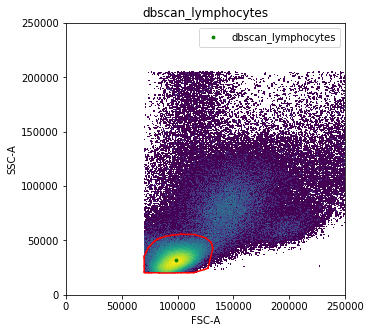

In [96]:
audited_apply(hc, 'dbscan_lymphocytes', 'manual_lymphocytes')

In [83]:
child_populations = ChildPopulationCollection('geom')

In [95]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('dbscan_lymphocytes', target=(75000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, distance_nn=5000, frac=0.2,nn=10)
hc.create_gate(gate_name='dbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='dbscan', kwargs=gate_definition, child_populations=child_populations)

True

In [84]:
child_populations.add_population('manual_lymphocytes', definition='+')
child_populations.add_population('manual_lymphocytes_NEG', definition='-')

<h3>DBSCAN</h3>

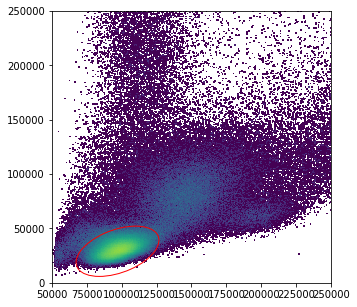

In [88]:
visualise_manual_ellipse(hc.get_population_df('root'), 'FSC-A', 'SSC-A', centroid=(97000, 29000), width=65000, height=38000, angle=30,
                        xlim=(50000, 250000), ylim=(0, 250000))

sample_id               method  f1_score  accuracy  precision    recall  \
0        hc1      gmm_lymphocytes  0.927860  0.900831   0.997905  0.867004   
1        hc1   dbscan_lymphocytes  0.985650  0.978874   0.984963  0.986338   
2        hc1  hdbscan_lymphocytes  0.966983  0.949970   0.939622  0.995985   
3        hc1   dens2d_lymphocytes  0.221310  0.355091   0.989539  0.124587   
4        hc4      gmm_lymphocytes  0.974289  0.961781   0.950037  0.999811   
5        hc4   dbscan_lymphocytes  0.980299  0.970954   0.963404  0.997798   
6        hc4  hdbscan_lymphocytes  0.976521  0.965339   0.958532  0.995198   
7        hc4   dens2d_lymphocytes  0.544030  0.541808   0.974107  0.377403   
8        hc5      gmm_lymphocytes  0.978192  0.970679   0.986523  0.970000   
9        hc5   dbscan_lymphocytes  0.979867  0.972223   0.963234  0.997084   
10       hc5  hdbscan_lymphocytes  0.976385  0.967337   0.957475  0.996057   
11       hc5   dens2d_lymphocytes  0.361958  0.470491   0.988272  0.221551   
12       hc7      gmm_lymphocytes  0.845585  0.833315   0.809681  0.884821   
13       hc7   dbscan_lymphocytes  0.910492  0.898710   0.836542  0.998783   
14       hc7  hdbscan_lymphocytes  0.899625  0.884908   0.817605  0.999936   
15       hc7   dens2d_lymphocytes  0.460371  0.614583   0.828525  0.318739   
16       hc9      gmm_lymphocytes  0.988764  0.981209   1.000000  0.977778   

          time  
0     6.115700  
1    13.159312  
2   468.238852  
3     3.719155  
4     4.871430  
5    11.819951  
6   231.729461  
7     1.653266  
8     2.633845  
9    11.912364  
10  212.598680  
11    1.538740  
12    2.929482  
13    7.924105  
14  273.524955  
15    2.300163  
16    5.527719

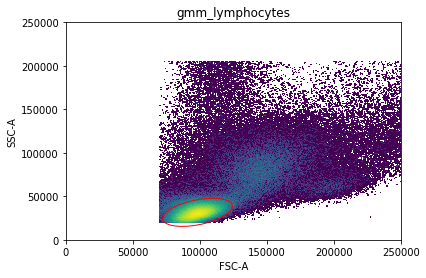

In [94]:
audited_apply(hc, 'gmm_lymphocytes', 'manual_lymphocytes')

In [89]:
gate_definition = dict(x='FSC-A', y='SSC-A', centroid=(97000, 29000), width=65000, height=38000, angle=30)
hc.create_gate(gate_name='manual_lymphocytes', parent='cells', class_='Static', method='ellipse_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

In [93]:
pre_filter = dict(xmin=50000, xmax=200000, ymin=0, ymax=150000)
gate_definition = dict(x='FSC-A', y='SSC-A', target=(70000, 40000), k=3, rect_filter=pre_filter,
                      conf=0.99)
hc.create_gate(gate_name='gmm_lymphocytes', parent='cells', class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)

True

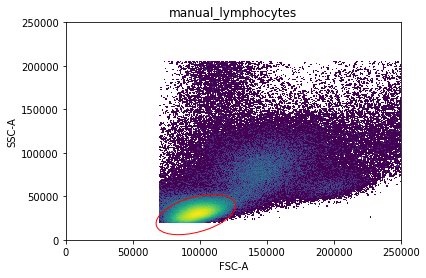

In [90]:
hc.apply('manual_lymphocytes')

In [92]:
child_populations.add_population('gmm_lymphocytes', definition='+')
child_populations.add_population('gmm_lymphocytes_NEG', definition='-')

<h3>Mixture Model</h3>

<h2>HC9</h2>

In [119]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('dbscan_lymphocytes', target=(75000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, distance_nn=5000, frac=0.2,nn=10)
hc.create_gate(gate_name='dbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='dbscan', kwargs=gate_definition, child_populations=child_populations)

True

<h3>DBSCAN</h3>

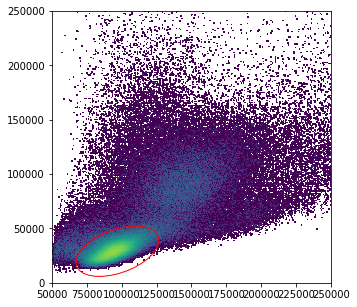

In [112]:
visualise_manual_ellipse(hc.get_population_df('root'), 'FSC-A', 'SSC-A', centroid=(97000, 29000), width=65000, height=38000, angle=30,
                        xlim=(50000, 250000), ylim=(0, 250000))

sample_id           method  f1_score  accuracy  precision    recall  \
20      hc10  gmm_lymphocytes  0.977026  0.964979        1.0  0.955085   

       time  
20  3.31229

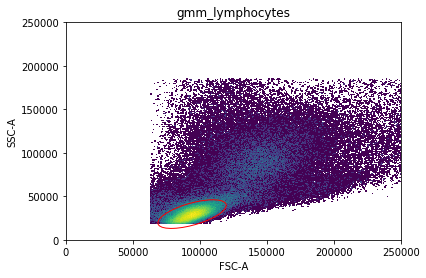

In [118]:
audited_apply(hc, 'gmm_lymphocytes', 'manual_lymphocytes')

In [113]:
gate_definition = dict(x='FSC-A', y='SSC-A', centroid=(97000, 29000), width=65000, height=38000, angle=30)
hc.create_gate(gate_name='manual_lymphocytes', parent='cells', class_='Static', method='ellipse_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

In [117]:
pre_filter = dict(xmin=50000, xmax=200000, ymin=0, ymax=150000)
gate_definition = dict(x='FSC-A', y='SSC-A', target=(70000, 40000), k=3, rect_filter=pre_filter,
                      conf=0.99)
hc.create_gate(gate_name='gmm_lymphocytes', parent='cells', class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)

True

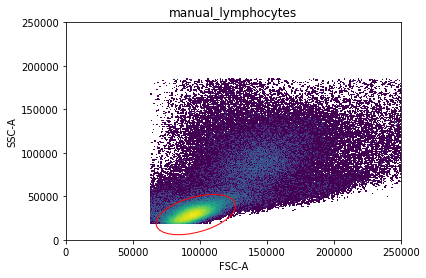

In [114]:
hc.apply('manual_lymphocytes')

In [116]:
child_populations.add_population('gmm_lymphocytes', definition='+')
child_populations.add_population('gmm_lymphocytes_NEG', definition='-')

<h3>Mixture Model</h3>

<h2>HC11</h2>

In [126]:
hc = Gating(exp, 'hc10')

In [149]:
pd.DataFrame(gating_performance).to_csv('algo_performance.csv', index=False)

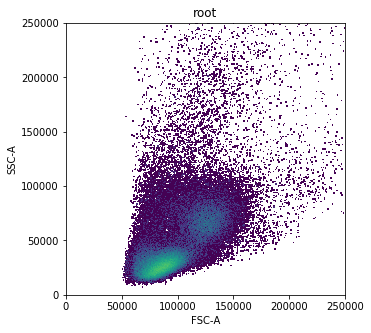

In [127]:
hc.plotting.plot_population('root', 'FSC-A', 'SSC-A')

sample_id               method  f1_score  accuracy  precision    recall  \
24      hc11      gmm_lymphocytes  0.976405  0.965605   0.982289  0.970591   
25      hc11   dbscan_lymphocytes  0.971075  0.958776   1.000000  0.943776   
26      hc11  hdbscan_lymphocytes  0.987346  0.981534   0.992224  0.982515   
27      hc11   dens2d_lymphocytes  0.787052  0.742300   0.998492  0.649511   

         time  
24   1.838434  
25   2.081772  
26  58.953747  
27   0.412572

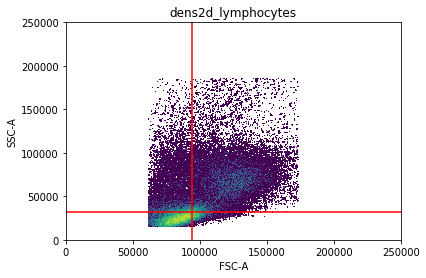

In [148]:
audited_apply(hc, 'dens2d_lymphocytes', 'manual_lymphocytes')

I will first apply a preprocessing gate that just removes artifacts in the extremes of the plot. This a measure that should be taken before all automated gating. It prevents high density regions of debris from disrupting the gating algorithm.

In [147]:
child_populations = ChildPopulationCollection('threshold_2d')
child_populations.add_population('dens2d_lymphocytes', definition='--')
child_populations.add_population('dens2d_lymphocytes_NEG', definition=['++', '+-', '-+'])
gate_definition = dict(x='FSC-A', y='SSC-A', kde_bw=0.1)
hc.create_gate(gate_name='dens2d_lymphocytes', parent='cells', class_='DensityThreshold', 
                 method='gate_2d', kwargs=gate_definition, child_populations=child_populations)

True

In [128]:
child_populations = ChildPopulationCollection('geom')

<h3>2D Density Threshold</h3>

In [129]:
child_populations.add_population('cells', definition='+')
child_populations.add_population('debris', definition='-')

sample_id               method  f1_score  accuracy  precision    recall  \
24      hc11      gmm_lymphocytes  0.976405  0.965605   0.982289  0.970591   
25      hc11   dbscan_lymphocytes  0.971075  0.958776   1.000000  0.943776   
26      hc11  hdbscan_lymphocytes  0.987346  0.981534   0.992224  0.982515   

         time  
24   1.838434  
25   2.081772  
26  58.953747

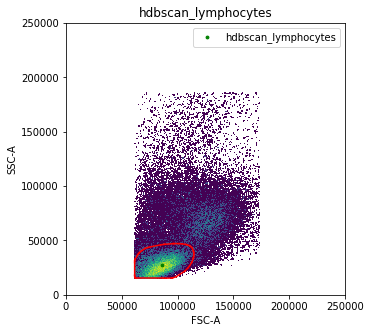

In [146]:
audited_apply(hc, 'hdbscan_lymphocytes', 'manual_lymphocytes')

In [130]:
gate_definition = dict(x='FSC-A', y='SSC-A')
hc.create_gate(gate_name='debris_gate', parent='root', class_='Static', method='border_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

In [145]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('hdbscan_lymphocytes', target=(70000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, frac=0.2)
hc.create_gate(gate_name='hdbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='hdbscan', kwargs=gate_definition, child_populations=child_populations)

True

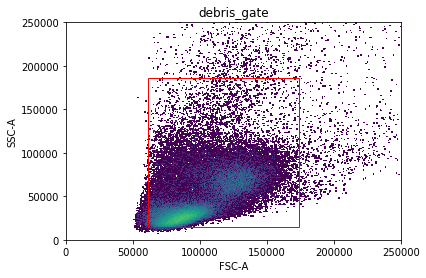

In [131]:
hc.apply('debris_gate')

<h3>HDBSCAN</h3>

<h3>Manual Gate<\h3>

sample_id              method  f1_score  accuracy  precision    recall  \
24      hc11     gmm_lymphocytes  0.976405  0.965605   0.982289  0.970591   
25      hc11  dbscan_lymphocytes  0.971075  0.958776   1.000000  0.943776   

        time  
24  1.838434  
25  2.081772

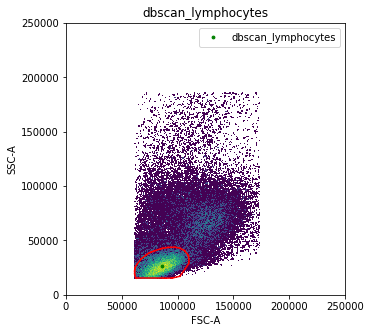

In [144]:
audited_apply(hc, 'dbscan_lymphocytes', 'manual_lymphocytes')

In [132]:
child_populations = ChildPopulationCollection('geom')

In [143]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('dbscan_lymphocytes', target=(75000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, distance_nn=5000, frac=0.2,nn=10)
hc.create_gate(gate_name='dbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='dbscan', kwargs=gate_definition, child_populations=child_populations)

True

In [133]:
child_populations.add_population('manual_lymphocytes', definition='+')
child_populations.add_population('manual_lymphocytes_NEG', definition='-')

<h3>DBSCAN</h3>

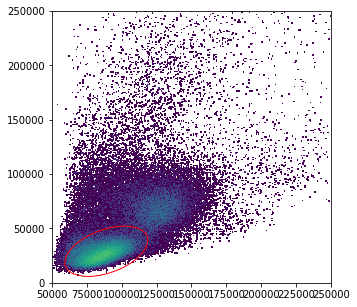

In [136]:
visualise_manual_ellipse(hc.get_population_df('root'), 'FSC-A', 'SSC-A', centroid=(89000, 29000), width=65000, height=38000, angle=30,
                        xlim=(50000, 250000), ylim=(0, 250000))

sample_id           method  f1_score  accuracy  precision    recall  \
24      hc11  gmm_lymphocytes  0.976405  0.965605   0.982289  0.970591   

        time  
24  1.838434

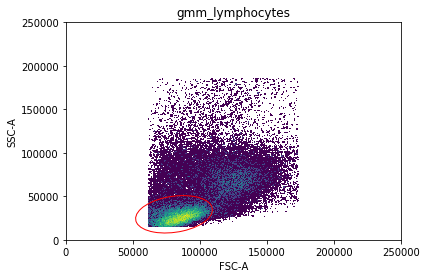

In [142]:
audited_apply(hc, 'gmm_lymphocytes', 'manual_lymphocytes')

In [137]:
gate_definition = dict(x='FSC-A', y='SSC-A', centroid=(89000, 29000), width=65000, height=38000, angle=30)
hc.create_gate(gate_name='manual_lymphocytes', parent='cells', class_='Static', method='ellipse_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

In [141]:
pre_filter = dict(xmin=50000, xmax=200000, ymin=0, ymax=150000)
gate_definition = dict(x='FSC-A', y='SSC-A', target=(70000, 40000), k=3, rect_filter=pre_filter,
                      conf=0.99)
hc.create_gate(gate_name='gmm_lymphocytes', parent='cells', class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)

True

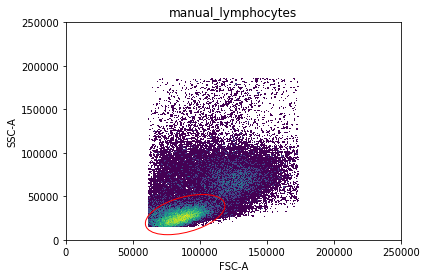

In [138]:
hc.apply('manual_lymphocytes')

In [140]:
child_populations.add_population('gmm_lymphocytes', definition='+')
child_populations.add_population('gmm_lymphocytes_NEG', definition='-')

<h3>Mixture Model</h3>

<h2>HC12</h2>

In [139]:
child_populations = ChildPopulationCollection('geom')

In [150]:
hc = Gating(exp, 'hc12')

In [171]:
pd.DataFrame(gating_performance).to_csv('algo_performance.csv', index=False)

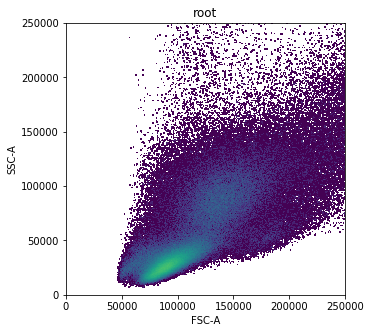

In [151]:
hc.plotting.plot_population('root', 'FSC-A', 'SSC-A')

sample_id               method  f1_score  accuracy  precision    recall  \
28      hc12      gmm_lymphocytes  0.959102  0.943982   0.996517  0.924395   
29      hc12   dbscan_lymphocytes  0.983500  0.976160   0.967636  0.999892   
30      hc12  hdbscan_lymphocytes  0.977506  0.967327   0.956827  0.999098   
31      hc12   dens2d_lymphocytes  0.542716  0.550022   0.976443  0.375792   

          time  
28    3.131196  
29   13.487836  
30  242.579844  
31    1.665854

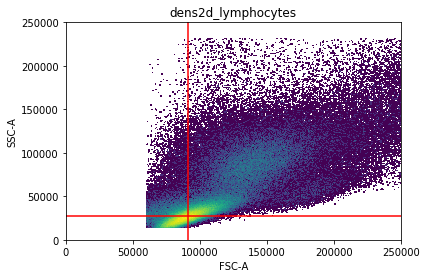

In [170]:
audited_apply(hc, 'dens2d_lymphocytes', 'manual_lymphocytes')

I will first apply a preprocessing gate that just removes artifacts in the extremes of the plot. This a measure that should be taken before all automated gating. It prevents high density regions of debris from disrupting the gating algorithm.

In [169]:
child_populations = ChildPopulationCollection('threshold_2d')
child_populations.add_population('dens2d_lymphocytes', definition='--')
child_populations.add_population('dens2d_lymphocytes_NEG', definition=['++', '+-', '-+'])
gate_definition = dict(x='FSC-A', y='SSC-A', kde_bw=0.1)
hc.create_gate(gate_name='dens2d_lymphocytes', parent='cells', class_='DensityThreshold', 
                 method='gate_2d', kwargs=gate_definition, child_populations=child_populations)

True

In [152]:
child_populations = ChildPopulationCollection('geom')

<h3>2D Density Threshold</h3>

In [153]:
child_populations.add_population('cells', definition='+')
child_populations.add_population('debris', definition='-')

sample_id               method  f1_score  accuracy  precision    recall  \
28      hc12      gmm_lymphocytes  0.959102  0.943982   0.996517  0.924395   
29      hc12   dbscan_lymphocytes  0.983500  0.976160   0.967636  0.999892   
30      hc12  hdbscan_lymphocytes  0.977506  0.967327   0.956827  0.999098   

          time  
28    3.131196  
29   13.487836  
30  242.579844

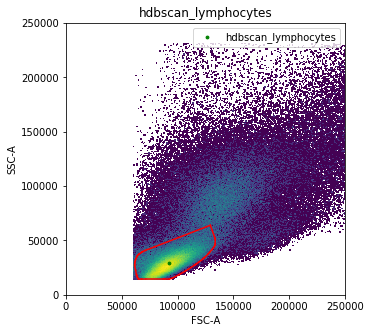

In [168]:
audited_apply(hc, 'hdbscan_lymphocytes', 'manual_lymphocytes')

In [154]:
gate_definition = dict(x='FSC-A', y='SSC-A')
hc.create_gate(gate_name='debris_gate', parent='root', class_='Static', method='border_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

In [167]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('hdbscan_lymphocytes', target=(70000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, frac=0.2)
hc.create_gate(gate_name='hdbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='hdbscan', kwargs=gate_definition, child_populations=child_populations)

True

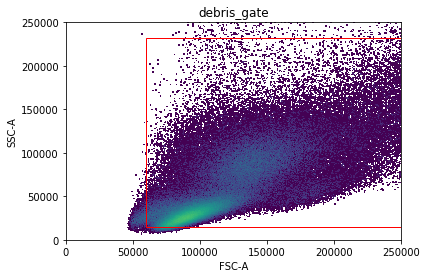

In [155]:
hc.apply('debris_gate')

<h3>HDBSCAN</h3>

<h3>Manual Gate<\h3>

sample_id              method  f1_score  accuracy  precision    recall  \
28      hc12     gmm_lymphocytes  0.959102  0.943982   0.996517  0.924395   
29      hc12  dbscan_lymphocytes  0.983500  0.976160   0.967636  0.999892   

         time  
28   3.131196  
29  13.487836

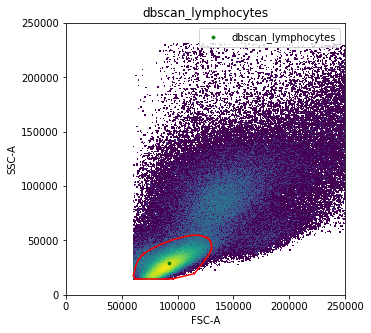

In [166]:
audited_apply(hc, 'dbscan_lymphocytes', 'manual_lymphocytes')

In [156]:
child_populations = ChildPopulationCollection('geom')

In [165]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('dbscan_lymphocytes', target=(75000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, distance_nn=5000, frac=0.2,nn=10)
hc.create_gate(gate_name='dbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='dbscan', kwargs=gate_definition, child_populations=child_populations)

True

In [157]:
child_populations.add_population('manual_lymphocytes', definition='+')
child_populations.add_population('manual_lymphocytes_NEG', definition='-')

<h3>DBSCAN</h3>

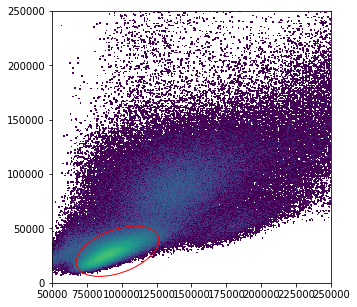

In [158]:
visualise_manual_ellipse(hc.get_population_df('root'), 'FSC-A', 'SSC-A', centroid=(97000, 29000), width=65000, height=38000, angle=30,
                        xlim=(50000, 250000), ylim=(0, 250000))

sample_id           method  f1_score  accuracy  precision    recall  \
28      hc12  gmm_lymphocytes  0.959102  0.943982   0.996517  0.924395   

        time  
28  3.131196

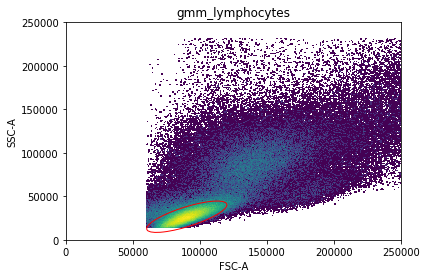

In [164]:
audited_apply(hc, 'gmm_lymphocytes', 'manual_lymphocytes')

In [159]:
gate_definition = dict(x='FSC-A', y='SSC-A', centroid=(97000, 29000), width=65000, height=38000, angle=30)
hc.create_gate(gate_name='manual_lymphocytes', parent='cells', class_='Static', method='ellipse_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

In [163]:
pre_filter = dict(xmin=50000, xmax=200000, ymin=0, ymax=150000)
gate_definition = dict(x='FSC-A', y='SSC-A', target=(70000, 40000), k=3, rect_filter=pre_filter,
                      conf=0.99)
hc.create_gate(gate_name='gmm_lymphocytes', parent='cells', class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)

True

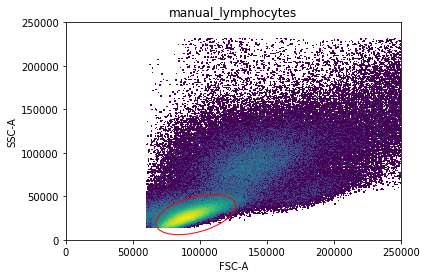

In [160]:
hc.apply('manual_lymphocytes')

In [162]:
child_populations.add_population('gmm_lymphocytes', definition='+')
child_populations.add_population('gmm_lymphocytes_NEG', definition='-')

<h3>Mixture Model</h3>

<h2>HC13</h2>

In [161]:
child_populations = ChildPopulationCollection('geom')

In [172]:
hc = Gating(exp, 'hc13')

In [193]:
pd.DataFrame(gating_performance).to_csv('algo_performance.csv', index=False)

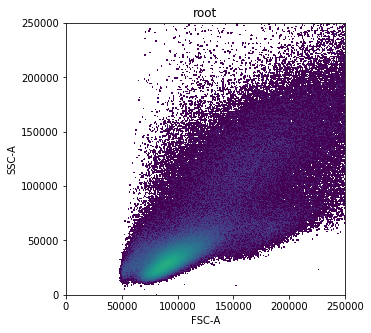

In [173]:
hc.plotting.plot_population('root', 'FSC-A', 'SSC-A')

sample_id               method  f1_score  accuracy  precision    recall  \
32      hc13      gmm_lymphocytes  0.969182  0.953136   0.995924  0.943839   
33      hc13   dbscan_lymphocytes  0.967723  0.947923   0.937552  0.999901   
34      hc13  hdbscan_lymphocytes  0.000000  0.219246   0.000000  0.000000   
35      hc13   dens2d_lymphocytes  0.422153  0.424334   0.975906  0.269329   

         time  
32   3.712367  
33  21.671567  
34  32.503516  
35   2.696521

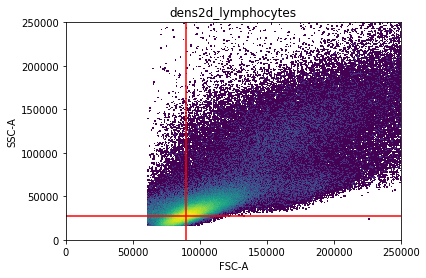

In [192]:
audited_apply(hc, 'dens2d_lymphocytes', 'manual_lymphocytes')

I will first apply a preprocessing gate that just removes artifacts in the extremes of the plot. This a measure that should be taken before all automated gating. It prevents high density regions of debris from disrupting the gating algorithm.

In [191]:
child_populations = ChildPopulationCollection('threshold_2d')
child_populations.add_population('dens2d_lymphocytes', definition='--')
child_populations.add_population('dens2d_lymphocytes_NEG', definition=['++', '+-', '-+'])
gate_definition = dict(x='FSC-A', y='SSC-A', kde_bw=0.1)
hc.create_gate(gate_name='dens2d_lymphocytes', parent='cells', class_='DensityThreshold', 
                 method='gate_2d', kwargs=gate_definition, child_populations=child_populations)

True

In [174]:
child_populations = ChildPopulationCollection('geom')

<h3>2D Density Threshold</h3>

In [175]:
child_populations.add_population('cells', definition='+')
child_populations.add_population('debris', definition='-')

Population ['hdbscan_lymphocytes'] assigned to noise (i.e. population not found)


No handles with labels found to put in legend.


sample_id               method  f1_score  accuracy  precision    recall  \
32      hc13      gmm_lymphocytes  0.969182  0.953136   0.995924  0.943839   
33      hc13   dbscan_lymphocytes  0.967723  0.947923   0.937552  0.999901   
34      hc13  hdbscan_lymphocytes  0.000000  0.219246   0.000000  0.000000   

         time  
32   3.712367  
33  21.671567  
34  32.503516

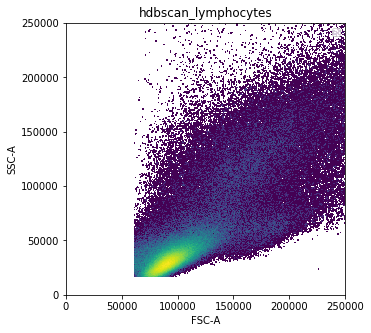

In [190]:
audited_apply(hc, 'hdbscan_lymphocytes', 'manual_lymphocytes')

In [176]:
gate_definition = dict(x='FSC-A', y='SSC-A')
hc.create_gate(gate_name='debris_gate', parent='root', class_='Static', method='border_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

In [189]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('hdbscan_lymphocytes', target=(70000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, frac=0.2)
hc.create_gate(gate_name='hdbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='hdbscan', kwargs=gate_definition, child_populations=child_populations)

True

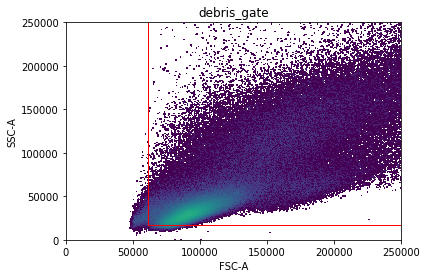

In [177]:
hc.apply('debris_gate')

<h3>HDBSCAN</h3>

<h3>Manual Gate<\h3>

sample_id              method  f1_score  accuracy  precision    recall  \
32      hc13     gmm_lymphocytes  0.969182  0.953136   0.995924  0.943839   
33      hc13  dbscan_lymphocytes  0.967723  0.947923   0.937552  0.999901   

         time  
32   3.712367  
33  21.671567

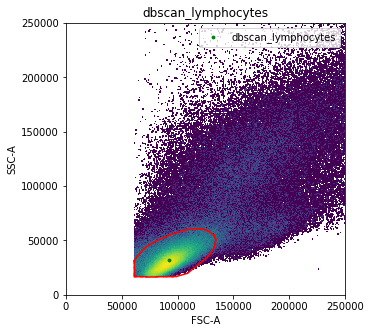

In [188]:
audited_apply(hc, 'dbscan_lymphocytes', 'manual_lymphocytes')

In [178]:
child_populations = ChildPopulationCollection('geom')

In [187]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('dbscan_lymphocytes', target=(75000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, distance_nn=5000, frac=0.2,nn=10)
hc.create_gate(gate_name='dbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='dbscan', kwargs=gate_definition, child_populations=child_populations)

True

In [179]:
child_populations.add_population('manual_lymphocytes', definition='+')
child_populations.add_population('manual_lymphocytes_NEG', definition='-')

<h3>DBSCAN</h3>

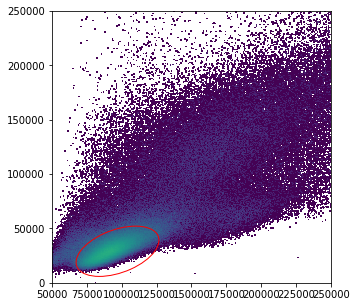

In [180]:
visualise_manual_ellipse(hc.get_population_df('root'), 'FSC-A', 'SSC-A', centroid=(97000, 29000), width=65000, height=38000, angle=30,
                        xlim=(50000, 250000), ylim=(0, 250000))

sample_id           method  f1_score  accuracy  precision    recall  \
32      hc13  gmm_lymphocytes  0.969182  0.953136   0.995924  0.943839   

        time  
32  3.712367

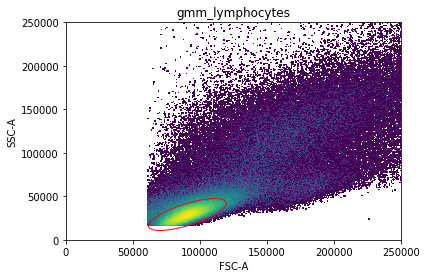

In [186]:
audited_apply(hc, 'gmm_lymphocytes', 'manual_lymphocytes')

In [181]:
gate_definition = dict(x='FSC-A', y='SSC-A', centroid=(97000, 29000), width=65000, height=38000, angle=30)
hc.create_gate(gate_name='manual_lymphocytes', parent='cells', class_='Static', method='ellipse_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

In [185]:
pre_filter = dict(xmin=50000, xmax=200000, ymin=0, ymax=150000)
gate_definition = dict(x='FSC-A', y='SSC-A', target=(70000, 40000), k=3, rect_filter=pre_filter,
                      conf=0.99)
hc.create_gate(gate_name='gmm_lymphocytes', parent='cells', class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)

True

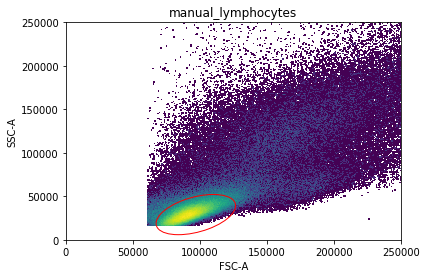

In [182]:
hc.apply('manual_lymphocytes')

In [184]:
child_populations.add_population('gmm_lymphocytes', definition='+')
child_populations.add_population('gmm_lymphocytes_NEG', definition='-')

<h3>Mixture Model</h3>

<h2>HC15</h2>

In [183]:
child_populations = ChildPopulationCollection('geom')

In [195]:
hc = Gating(exp, 'hc15')

In [220]:
pd.DataFrame(gating_performance).to_csv('algo_performance.csv', index=False)

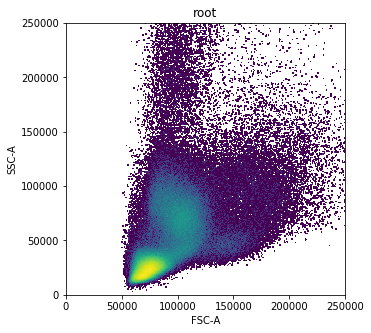

In [196]:
hc.plotting.plot_population('root', 'FSC-A', 'SSC-A')

sample_id               method  f1_score  accuracy  precision    recall  \
36      hc15      gmm_lymphocytes  0.958385  0.938172   0.985433  0.932782   
37      hc15   dbscan_lymphocytes  0.903397  0.836768   0.823814  1.000000   
38      hc15  hdbscan_lymphocytes  0.987900  0.981400   0.981087  0.994809   
39      hc15   dens2d_lymphocytes  0.452290  0.459799   1.000000  0.292232   

          time  
36    5.332847  
37   37.872322  
38  475.763510  
39    4.933916

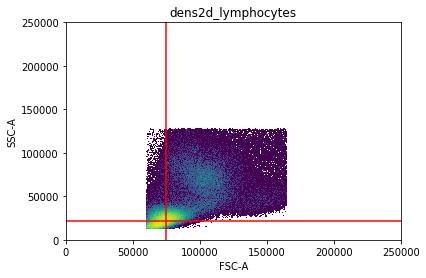

In [219]:
audited_apply(hc, 'dens2d_lymphocytes', 'manual_lymphocytes')

I will first apply a preprocessing gate that just removes artifacts in the extremes of the plot. This a measure that should be taken before all automated gating. It prevents high density regions of debris from disrupting the gating algorithm.

In [218]:
child_populations = ChildPopulationCollection('threshold_2d')
child_populations.add_population('dens2d_lymphocytes', definition='--')
child_populations.add_population('dens2d_lymphocytes_NEG', definition=['++', '+-', '-+'])
gate_definition = dict(x='FSC-A', y='SSC-A', kde_bw=0.1)
hc.create_gate(gate_name='dens2d_lymphocytes', parent='cells', class_='DensityThreshold', 
                 method='gate_2d', kwargs=gate_definition, child_populations=child_populations)

True

In [197]:
child_populations = ChildPopulationCollection('geom')

<h3>2D Density Threshold</h3>

In [198]:
child_populations.add_population('cells', definition='+')
child_populations.add_population('debris', definition='-')

sample_id               method  f1_score  accuracy  precision    recall  \
36      hc15      gmm_lymphocytes  0.958385  0.938172   0.985433  0.932782   
37      hc15   dbscan_lymphocytes  0.903397  0.836768   0.823814  1.000000   
38      hc15  hdbscan_lymphocytes  0.987900  0.981400   0.981087  0.994809   

          time  
36    5.332847  
37   37.872322  
38  475.763510

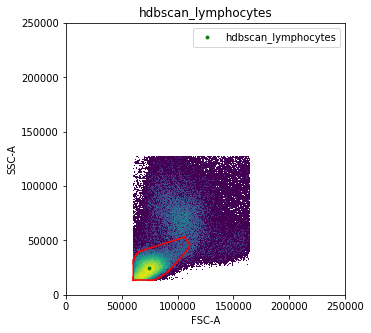

In [217]:
audited_apply(hc, 'hdbscan_lymphocytes', 'manual_lymphocytes')

In [199]:
gate_definition = dict(x='FSC-A', y='SSC-A')
hc.create_gate(gate_name='debris_gate', parent='root', class_='Static', method='border_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

In [216]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('hdbscan_lymphocytes', target=(70000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, frac=0.2)
hc.create_gate(gate_name='hdbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='hdbscan', kwargs=gate_definition, child_populations=child_populations)

True

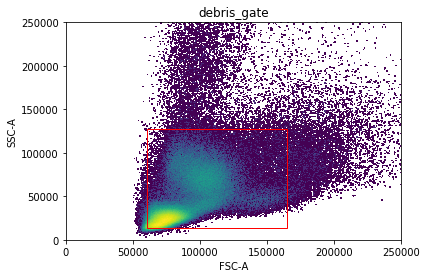

In [200]:
hc.apply('debris_gate')

<h3>HDBSCAN</h3>

<h3>Manual Gate<\h3>

sample_id              method  f1_score  accuracy  precision    recall  \
36      hc15     gmm_lymphocytes  0.958385  0.938172   0.985433  0.932782   
37      hc15  dbscan_lymphocytes  0.903397  0.836768   0.823814  1.000000   

         time  
36   5.332847  
37  37.872322

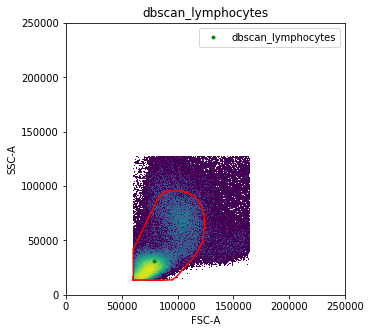

In [215]:
audited_apply(hc, 'dbscan_lymphocytes', 'manual_lymphocytes')

In [201]:
child_populations = ChildPopulationCollection('geom')

In [214]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('dbscan_lymphocytes', target=(75000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, distance_nn=5000, frac=0.2,nn=10)
hc.create_gate(gate_name='dbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='dbscan', kwargs=gate_definition, child_populations=child_populations)

True

In [202]:
child_populations.add_population('manual_lymphocytes', definition='+')
child_populations.add_population('manual_lymphocytes_NEG', definition='-')

<h3>DBSCAN</h3>

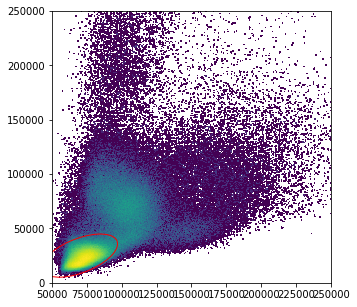

In [207]:
visualise_manual_ellipse(hc.get_population_df('root'), 'FSC-A', 'SSC-A', centroid=(70000, 25000), width=60000, height=30000, angle=30,
                        xlim=(50000, 250000), ylim=(0, 250000))

sample_id           method  f1_score  accuracy  precision    recall  \
36      hc15  gmm_lymphocytes  0.958385  0.938172   0.985433  0.932782   

        time  
36  5.332847

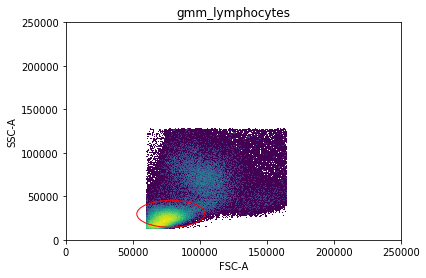

In [213]:
audited_apply(hc, 'gmm_lymphocytes', 'manual_lymphocytes')

In [208]:
gate_definition = dict(x='FSC-A', y='SSC-A', centroid=(70000, 25000), width=60000, height=30000, angle=30)
hc.create_gate(gate_name='manual_lymphocytes', parent='cells', class_='Static', method='ellipse_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

In [212]:
pre_filter = dict(xmin=50000, xmax=200000, ymin=0, ymax=150000)
gate_definition = dict(x='FSC-A', y='SSC-A', target=(70000, 40000), k=3, rect_filter=pre_filter,
                      conf=0.99)
hc.create_gate(gate_name='gmm_lymphocytes', parent='cells', class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)

True

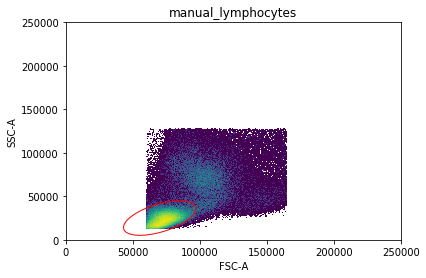

In [209]:
hc.apply('manual_lymphocytes')

In [211]:
child_populations.add_population('gmm_lymphocytes', definition='+')
child_populations.add_population('gmm_lymphocytes_NEG', definition='-')

<h3>Mixture Model</h3>

<h2>HC16</h2>

In [210]:
child_populations = ChildPopulationCollection('geom')

In [221]:
hc = Gating(exp, 'hc16')

In [250]:
pd.DataFrame(gating_performance).to_csv('algo_performance.csv', index=False)

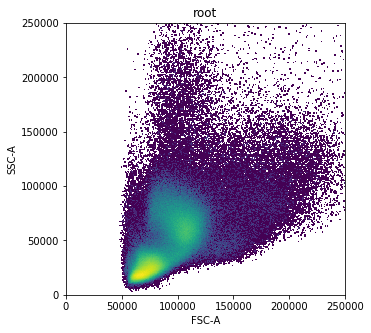

In [222]:
hc.plotting.plot_population('root', 'FSC-A', 'SSC-A')

sample_id               method  f1_score  accuracy  precision    recall  \
40      hc16      gmm_lymphocytes  0.987227  0.984147   0.999635  0.975124   
41      hc16   dbscan_lymphocytes  0.790148  0.666267   0.653095  1.000000   
42      hc16  hdbscan_lymphocytes  0.991415  0.989147   0.985459  0.997444   
43      hc16   dens2d_lymphocytes  0.541721  0.605102   1.000000  0.371480   

          time  
40    7.823359  
41   64.270260  
42  749.460580  
43    5.999307

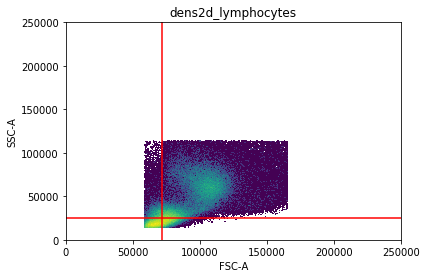

In [249]:
audited_apply(hc, 'dens2d_lymphocytes', 'manual_lymphocytes')

I will first apply a preprocessing gate that just removes artifacts in the extremes of the plot. This a measure that should be taken before all automated gating. It prevents high density regions of debris from disrupting the gating algorithm.

In [248]:
child_populations = ChildPopulationCollection('threshold_2d')
child_populations.add_population('dens2d_lymphocytes', definition='--')
child_populations.add_population('dens2d_lymphocytes_NEG', definition=['++', '+-', '-+'])
gate_definition = dict(x='FSC-A', y='SSC-A', kde_bw=0.1)
hc.create_gate(gate_name='dens2d_lymphocytes', parent='cells', class_='DensityThreshold', 
                 method='gate_2d', kwargs=gate_definition, child_populations=child_populations)

True

In [223]:
child_populations = ChildPopulationCollection('geom')

<h3>2D Density Threshold</h3>

In [224]:
child_populations.add_population('cells', definition='+')
child_populations.add_population('debris', definition='-')

sample_id               method  f1_score  accuracy  precision    recall  \
40      hc16      gmm_lymphocytes  0.987227  0.984147   0.999635  0.975124   
41      hc16   dbscan_lymphocytes  0.790148  0.666267   0.653095  1.000000   
42      hc16  hdbscan_lymphocytes  0.991415  0.989147   0.985459  0.997444   

          time  
40    7.823359  
41   64.270260  
42  749.460580

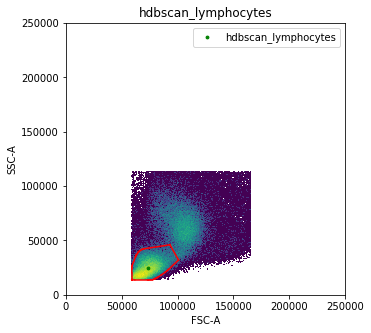

In [247]:
audited_apply(hc, 'hdbscan_lymphocytes', 'manual_lymphocytes')

In [225]:
gate_definition = dict(x='FSC-A', y='SSC-A')
hc.create_gate(gate_name='debris_gate', parent='root', class_='Static', method='border_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

In [246]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('hdbscan_lymphocytes', target=(70000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, frac=0.2)
hc.create_gate(gate_name='hdbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='hdbscan', kwargs=gate_definition, child_populations=child_populations)

True

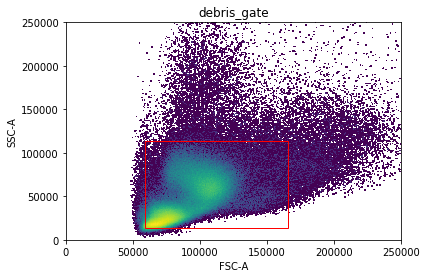

In [226]:
hc.apply('debris_gate')

<h3>HDBSCAN</h3>

<h3>Manual Gate<\h3>

sample_id              method  f1_score  accuracy  precision    recall  \
40      hc16     gmm_lymphocytes  0.987227  0.984147   0.999635  0.975124   
41      hc16  dbscan_lymphocytes  0.790148  0.666267   0.653095  1.000000   

         time  
40   7.823359  
41  64.270260

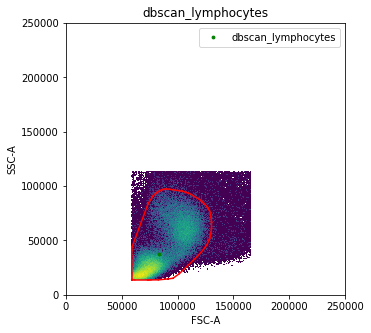

In [245]:
audited_apply(hc, 'dbscan_lymphocytes', 'manual_lymphocytes')

In [227]:
child_populations = ChildPopulationCollection('geom')

In [244]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('dbscan_lymphocytes', target=(75000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, distance_nn=5000, frac=0.2,nn=10)
hc.create_gate(gate_name='dbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='dbscan', kwargs=gate_definition, child_populations=child_populations)

True

In [228]:
child_populations.add_population('manual_lymphocytes', definition='+')
child_populations.add_population('manual_lymphocytes_NEG', definition='-')

<h3>DBSCAN</h3>

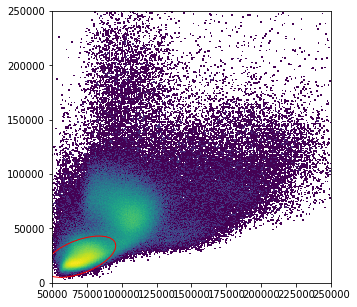

In [235]:
visualise_manual_ellipse(hc.get_population_df('root'), 'FSC-A', 'SSC-A', centroid=(70000, 24000), width=57000, height=29000, angle=30,
                        xlim=(50000, 250000), ylim=(0, 250000))

sample_id           method  f1_score  accuracy  precision    recall  \
40      hc16  gmm_lymphocytes  0.987227  0.984147   0.999635  0.975124   

        time  
40  7.823359

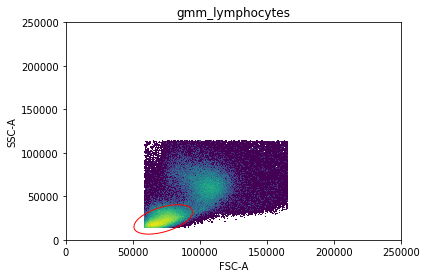

In [243]:
audited_apply(hc, 'gmm_lymphocytes', 'manual_lymphocytes')

In [238]:
gate_definition = dict(x='FSC-A', y='SSC-A', centroid=(70000, 24000), width=57000, height=29000, angle=30)
hc.create_gate(gate_name='manual_lymphocytes', parent='cells', class_='Static', method='ellipse_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

In [242]:
pre_filter = dict(xmin=50000, xmax=200000, ymin=0, ymax=150000)
gate_definition = dict(x='FSC-A', y='SSC-A', target=(70000, 40000), k=3, rect_filter=pre_filter,
                      conf=0.99)
hc.create_gate(gate_name='gmm_lymphocytes', parent='cells', class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)

True

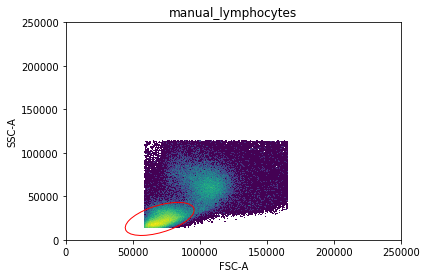

In [239]:
hc.apply('manual_lymphocytes')

In [241]:
child_populations.add_population('gmm_lymphocytes', definition='+')
child_populations.add_population('gmm_lymphocytes_NEG', definition='-')

<h3>Mixture Model</h3>

<h2>HC17</h2>

In [240]:
child_populations = ChildPopulationCollection('geom')

In [251]:
hc = Gating(exp, 'hc17')

In [280]:
pd.DataFrame(gating_performance).to_csv('algo_performance.csv', index=False)

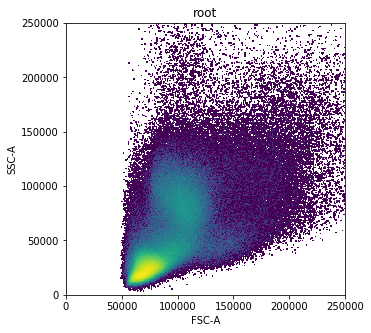

In [252]:
hc.plotting.plot_population('root', 'FSC-A', 'SSC-A')

sample_id               method  f1_score  accuracy  precision    recall  \
44      hc17      gmm_lymphocytes  0.996978  0.995771   0.997974  0.995985   
45      hc17   dbscan_lymphocytes  0.864736  0.780827   0.761704  1.000000   
46      hc17  hdbscan_lymphocytes  0.923914  0.884613   0.858588  1.000000   
47      hc17   dens2d_lymphocytes  0.341609  0.443733   1.000000  0.205988   

          time  
44    6.506478  
45  175.254629  
46  755.563951  
47    9.287569

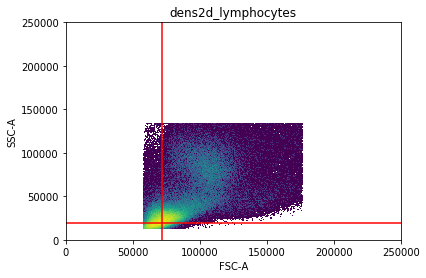

In [279]:
audited_apply(hc, 'dens2d_lymphocytes', 'manual_lymphocytes')

I will first apply a preprocessing gate that just removes artifacts in the extremes of the plot. This a measure that should be taken before all automated gating. It prevents high density regions of debris from disrupting the gating algorithm.

In [278]:
child_populations = ChildPopulationCollection('threshold_2d')
child_populations.add_population('dens2d_lymphocytes', definition='--')
child_populations.add_population('dens2d_lymphocytes_NEG', definition=['++', '+-', '-+'])
gate_definition = dict(x='FSC-A', y='SSC-A', kde_bw=0.1)
hc.create_gate(gate_name='dens2d_lymphocytes', parent='cells', class_='DensityThreshold', 
                 method='gate_2d', kwargs=gate_definition, child_populations=child_populations)

True

In [253]:
child_populations = ChildPopulationCollection('geom')

<h3>2D Density Threshold</h3>

In [254]:
child_populations.add_population('cells', definition='+')
child_populations.add_population('debris', definition='-')

sample_id               method  f1_score  accuracy  precision    recall  \
44      hc17      gmm_lymphocytes  0.996978  0.995771   0.997974  0.995985   
45      hc17   dbscan_lymphocytes  0.864736  0.780827   0.761704  1.000000   
46      hc17  hdbscan_lymphocytes  0.923914  0.884613   0.858588  1.000000   

          time  
44    6.506478  
45  175.254629  
46  755.563951

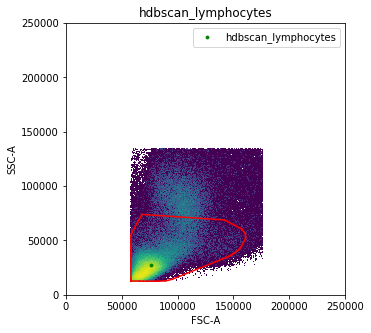

In [277]:
audited_apply(hc, 'hdbscan_lymphocytes', 'manual_lymphocytes')

In [255]:
gate_definition = dict(x='FSC-A', y='SSC-A')
hc.create_gate(gate_name='debris_gate', parent='root', class_='Static', method='border_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

In [276]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('hdbscan_lymphocytes', target=(70000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, frac=0.2)
hc.create_gate(gate_name='hdbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='hdbscan', kwargs=gate_definition, child_populations=child_populations)

True

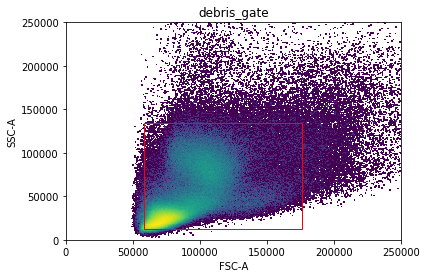

In [256]:
hc.apply('debris_gate')

<h3>HDBSCAN</h3>

<h3>Manual Gate<\h3>

sample_id              method  f1_score  accuracy  precision    recall  \
44      hc17     gmm_lymphocytes  0.996978  0.995771   0.997974  0.995985   
45      hc17  dbscan_lymphocytes  0.864736  0.780827   0.761704  1.000000   

          time  
44    6.506478  
45  175.254629

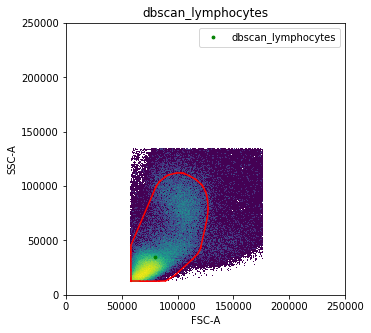

In [275]:
audited_apply(hc, 'dbscan_lymphocytes', 'manual_lymphocytes')

In [257]:
child_populations = ChildPopulationCollection('geom')

In [274]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('dbscan_lymphocytes', target=(75000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, distance_nn=5000, frac=0.2,nn=10)
hc.create_gate(gate_name='dbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='dbscan', kwargs=gate_definition, child_populations=child_populations)

True

In [258]:
child_populations.add_population('manual_lymphocytes', definition='+')
child_populations.add_population('manual_lymphocytes_NEG', definition='-')

<h3>DBSCAN</h3>

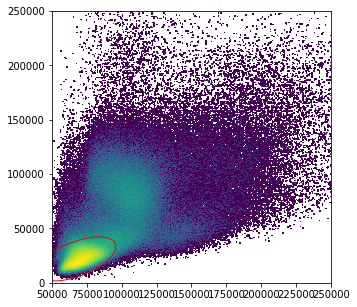

In [265]:
visualise_manual_ellipse(hc.get_population_df('root'), 'FSC-A', 'SSC-A', centroid=(68000, 22000), width=62000, height=30000, angle=30,
                        xlim=(50000, 250000), ylim=(0, 250000))

sample_id           method  f1_score  accuracy  precision    recall  \
44      hc17  gmm_lymphocytes  0.996978  0.995771   0.997974  0.995985   

        time  
44  6.506478

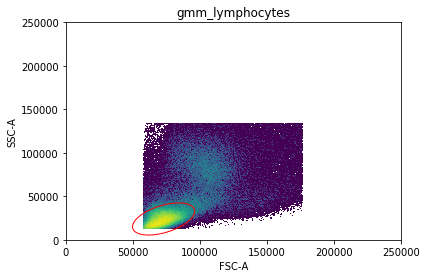

In [273]:
audited_apply(hc, 'gmm_lymphocytes', 'manual_lymphocytes')

In [268]:
gate_definition = dict(x='FSC-A', y='SSC-A', centroid=(68000, 22000), width=62000, height=30000, angle=30)
hc.create_gate(gate_name='manual_lymphocytes', parent='cells', class_='Static', method='ellipse_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

In [272]:
pre_filter = dict(xmin=50000, xmax=200000, ymin=0, ymax=150000)
gate_definition = dict(x='FSC-A', y='SSC-A', target=(70000, 40000), k=3, rect_filter=pre_filter,
                      conf=0.99)
hc.create_gate(gate_name='gmm_lymphocytes', parent='cells', class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)

True

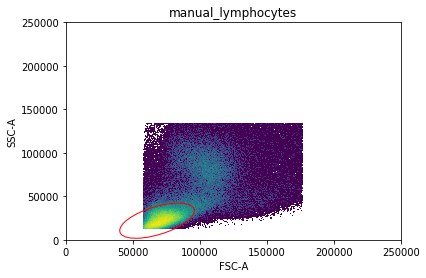

In [269]:
hc.apply('manual_lymphocytes')

In [271]:
child_populations.add_population('gmm_lymphocytes', definition='+')
child_populations.add_population('gmm_lymphocytes_NEG', definition='-')

<h3>Mixture Model</h3>

<h2>HC18</h2>

In [270]:
child_populations = ChildPopulationCollection('geom')

In [281]:
hc = Gating(exp, 'hc18')

In [306]:
pd.DataFrame(gating_performance).to_csv('algo_performance.csv', index=False)

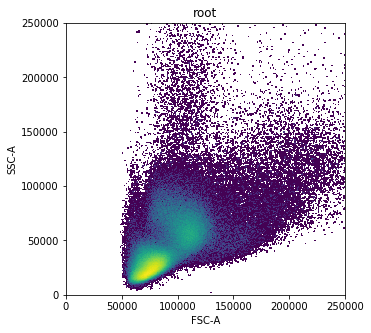

In [282]:
hc.plotting.plot_population('root', 'FSC-A', 'SSC-A')

sample_id               method  f1_score  accuracy  precision    recall  \
48      hc18      gmm_lymphocytes  0.959180  0.939969   0.979908  0.939310   
49      hc18   dbscan_lymphocytes  0.891024  0.816333   0.803466  1.000000   
50      hc18  hdbscan_lymphocytes  0.995732  0.993588   0.995207  0.996258   
51      hc18   dens2d_lymphocytes  0.488356  0.491298   0.997486  0.323326   

          time  
48    4.807156  
49  200.498922  
50  398.368421  
51    4.384569

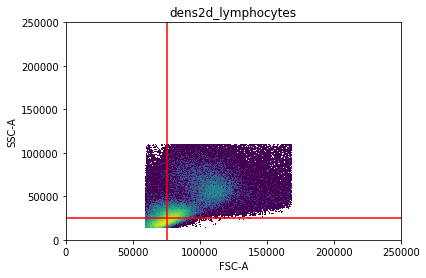

In [305]:
audited_apply(hc, 'dens2d_lymphocytes', 'manual_lymphocytes')

I will first apply a preprocessing gate that just removes artifacts in the extremes of the plot. This a measure that should be taken before all automated gating. It prevents high density regions of debris from disrupting the gating algorithm.

In [304]:
child_populations = ChildPopulationCollection('threshold_2d')
child_populations.add_population('dens2d_lymphocytes', definition='--')
child_populations.add_population('dens2d_lymphocytes_NEG', definition=['++', '+-', '-+'])
gate_definition = dict(x='FSC-A', y='SSC-A', kde_bw=0.1)
hc.create_gate(gate_name='dens2d_lymphocytes', parent='cells', class_='DensityThreshold', 
                 method='gate_2d', kwargs=gate_definition, child_populations=child_populations)

True

In [283]:
child_populations = ChildPopulationCollection('geom')

<h3>2D Density Threshold</h3>

In [284]:
child_populations.add_population('cells', definition='+')
child_populations.add_population('debris', definition='-')

sample_id               method  f1_score  accuracy  precision    recall  \
48      hc18      gmm_lymphocytes  0.959180  0.939969   0.979908  0.939310   
49      hc18   dbscan_lymphocytes  0.891024  0.816333   0.803466  1.000000   
50      hc18  hdbscan_lymphocytes  0.995732  0.993588   0.995207  0.996258   

          time  
48    4.807156  
49  200.498922  
50  398.368421

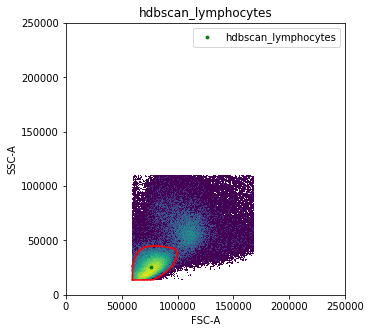

In [303]:
audited_apply(hc, 'hdbscan_lymphocytes', 'manual_lymphocytes')

In [285]:
gate_definition = dict(x='FSC-A', y='SSC-A')
hc.create_gate(gate_name='debris_gate', parent='root', class_='Static', method='border_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

In [302]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('hdbscan_lymphocytes', target=(70000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, frac=0.2)
hc.create_gate(gate_name='hdbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='hdbscan', kwargs=gate_definition, child_populations=child_populations)

True

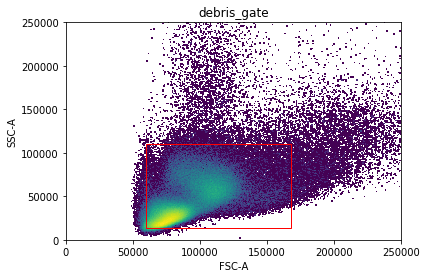

In [286]:
hc.apply('debris_gate')

<h3>HDBSCAN</h3>

<h3>Manual Gate<\h3>

sample_id              method  f1_score  accuracy  precision   recall  \
48      hc18     gmm_lymphocytes  0.959180  0.939969   0.979908  0.93931   
49      hc18  dbscan_lymphocytes  0.891024  0.816333   0.803466  1.00000   

          time  
48    4.807156  
49  200.498922

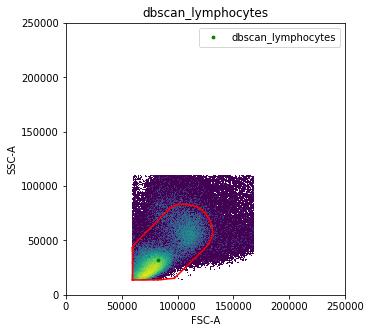

In [301]:
audited_apply(hc, 'dbscan_lymphocytes', 'manual_lymphocytes')

In [287]:
child_populations = ChildPopulationCollection('geom')

In [300]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('dbscan_lymphocytes', target=(75000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, distance_nn=5000, frac=0.2,nn=10)
hc.create_gate(gate_name='dbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='dbscan', kwargs=gate_definition, child_populations=child_populations)

True

In [288]:
child_populations.add_population('manual_lymphocytes', definition='+')
child_populations.add_population('manual_lymphocytes_NEG', definition='-')

<h3>DBSCAN</h3>

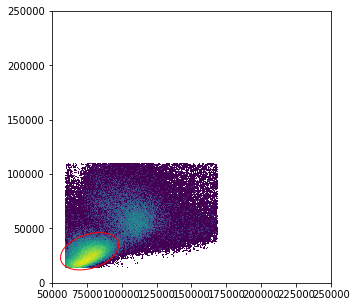

In [293]:
visualise_manual_ellipse(hc.get_population_df('cells'), 'FSC-A', 'SSC-A', centroid=(77000, 29000), width=45000, height=30000, angle=30,
                        xlim=(50000, 250000), ylim=(0, 250000))

sample_id           method  f1_score  accuracy  precision   recall  \
48      hc18  gmm_lymphocytes   0.95918  0.939969   0.979908  0.93931   

        time  
48  4.807156

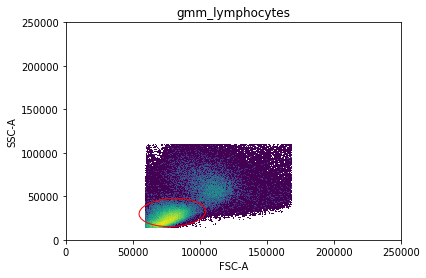

In [299]:
audited_apply(hc, 'gmm_lymphocytes', 'manual_lymphocytes')

In [294]:
gate_definition = dict(x='FSC-A', y='SSC-A', centroid=(77000, 29000), width=45000, height=30000, angle=30)
hc.create_gate(gate_name='manual_lymphocytes', parent='cells', class_='Static', method='ellipse_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

In [298]:
pre_filter = dict(xmin=50000, xmax=200000, ymin=0, ymax=150000)
gate_definition = dict(x='FSC-A', y='SSC-A', target=(70000, 40000), k=3, rect_filter=pre_filter,
                      conf=0.99)
hc.create_gate(gate_name='gmm_lymphocytes', parent='cells', class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)

True

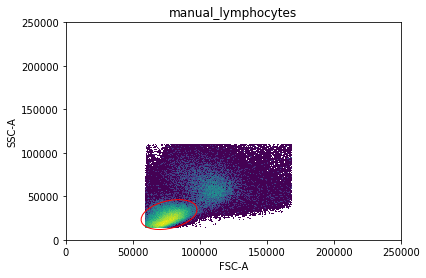

In [295]:
hc.apply('manual_lymphocytes')

In [297]:
child_populations.add_population('gmm_lymphocytes', definition='+')
child_populations.add_population('gmm_lymphocytes_NEG', definition='-')

<h2>HC19</h2>

In [296]:
child_populations = ChildPopulationCollection('geom')

In [307]:
hc = Gating(exp, 'hc19')

In [332]:
pd.DataFrame(gating_performance).to_csv('algo_performance.csv', index=False)

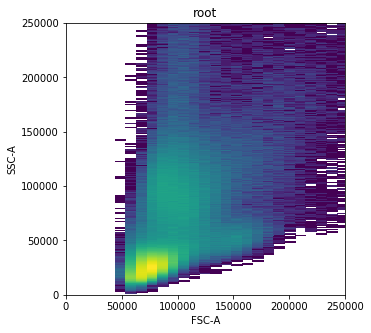

In [308]:
hc.plotting.plot_population('root', 'FSC-A', 'SSC-A')

sample_id               method  f1_score  accuracy  precision    recall  \
52      hc19      gmm_lymphocytes  0.983911  0.974835   1.000000  0.968331   
53      hc19   dbscan_lymphocytes  0.994640  0.991439   0.989658  0.999673   
54      hc19  hdbscan_lymphocytes  0.991332  0.986104   0.982855  0.999956   
55      hc19   dens2d_lymphocytes  0.171656  0.279994   1.000000  0.093886   

          time  
52    4.284299  
53   42.041590  
54  428.787164  
55    3.332418

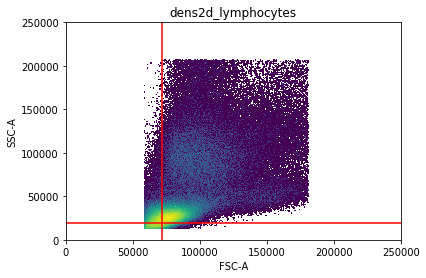

In [331]:
audited_apply(hc, 'dens2d_lymphocytes', 'manual_lymphocytes')

I will first apply a preprocessing gate that just removes artifacts in the extremes of the plot. This a measure that should be taken before all automated gating. It prevents high density regions of debris from disrupting the gating algorithm.

In [330]:
child_populations = ChildPopulationCollection('threshold_2d')
child_populations.add_population('dens2d_lymphocytes', definition='--')
child_populations.add_population('dens2d_lymphocytes_NEG', definition=['++', '+-', '-+'])
gate_definition = dict(x='FSC-A', y='SSC-A', kde_bw=0.1)
hc.create_gate(gate_name='dens2d_lymphocytes', parent='cells', class_='DensityThreshold', 
                 method='gate_2d', kwargs=gate_definition, child_populations=child_populations)

True

In [309]:
child_populations = ChildPopulationCollection('geom')

<h3>2D Density Threshold</h3>

In [310]:
child_populations.add_population('cells', definition='+')
child_populations.add_population('debris', definition='-')

sample_id               method  f1_score  accuracy  precision    recall  \
52      hc19      gmm_lymphocytes  0.983911  0.974835   1.000000  0.968331   
53      hc19   dbscan_lymphocytes  0.994640  0.991439   0.989658  0.999673   
54      hc19  hdbscan_lymphocytes  0.991332  0.986104   0.982855  0.999956   

          time  
52    4.284299  
53   42.041590  
54  428.787164

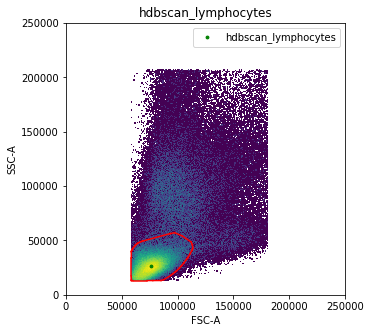

In [329]:
audited_apply(hc, 'hdbscan_lymphocytes', 'manual_lymphocytes')

In [311]:
gate_definition = dict(x='FSC-A', y='SSC-A')
hc.create_gate(gate_name='debris_gate', parent='root', class_='Static', method='border_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

In [328]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('hdbscan_lymphocytes', target=(70000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, frac=0.2)
hc.create_gate(gate_name='hdbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='hdbscan', kwargs=gate_definition, child_populations=child_populations)

True

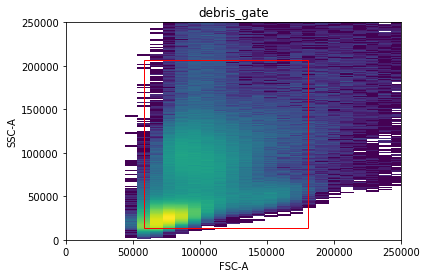

In [312]:
hc.apply('debris_gate')

<h3>HDBSCAN</h3>

<h3>Manual Gate<\h3>

sample_id              method  f1_score  accuracy  precision    recall  \
52      hc19     gmm_lymphocytes  0.983911  0.974835   1.000000  0.968331   
53      hc19  dbscan_lymphocytes  0.994640  0.991439   0.989658  0.999673   

         time  
52   4.284299  
53  42.041590

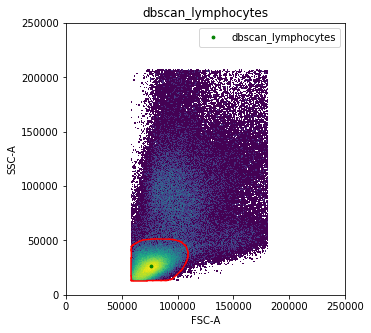

In [327]:
audited_apply(hc, 'dbscan_lymphocytes', 'manual_lymphocytes')

In [313]:
child_populations = ChildPopulationCollection('geom')

In [326]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('dbscan_lymphocytes', target=(75000, 40000), weight=1)
gate_definition = dict(x='FSC-A', y='SSC-A', min_pop_size=1000, distance_nn=5000, frac=0.2,nn=10)
hc.create_gate(gate_name='dbscan_lymphocytes', parent='cells', class_='DensityBasedClustering', 
                 method='dbscan', kwargs=gate_definition, child_populations=child_populations)

True

In [314]:
child_populations.add_population('manual_lymphocytes', definition='+')
child_populations.add_population('manual_lymphocytes_NEG', definition='-')

<h3>DBSCAN</h3>

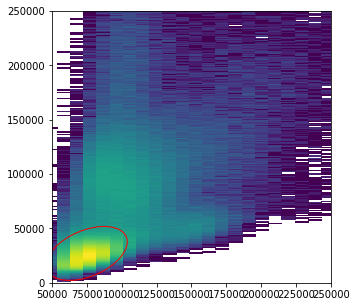

In [319]:
visualise_manual_ellipse(hc.get_population_df('root'), 'FSC-A', 'SSC-A', centroid=(75000, 27000), width=65000, height=40000, angle=35,
                        xlim=(50000, 250000), ylim=(0, 250000))

sample_id           method  f1_score  accuracy  precision    recall  \
52      hc19  gmm_lymphocytes  0.983911  0.974835        1.0  0.968331   

        time  
52  4.284299

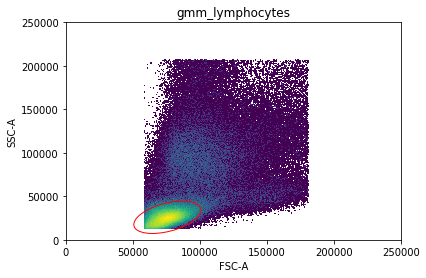

In [325]:
audited_apply(hc, 'gmm_lymphocytes', 'manual_lymphocytes')

In [320]:
gate_definition = dict(x='FSC-A', y='SSC-A', centroid=(75000, 27000), width=65000, height=40000, angle=35)
hc.create_gate(gate_name='manual_lymphocytes', parent='cells', class_='Static', method='ellipse_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

In [324]:
pre_filter = dict(xmin=50000, xmax=200000, ymin=0, ymax=150000)
gate_definition = dict(x='FSC-A', y='SSC-A', target=(70000, 40000), k=3, rect_filter=pre_filter,
                      conf=0.99)
hc.create_gate(gate_name='gmm_lymphocytes', parent='cells', class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)

True

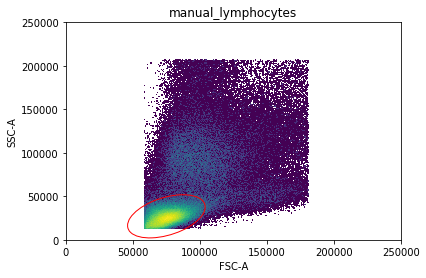

In [321]:
hc.apply('manual_lymphocytes')

In [323]:
child_populations.add_population('gmm_lymphocytes', definition='+')
child_populations.add_population('gmm_lymphocytes_NEG', definition='-')

<h1>Results</h1>

In [3]:
gating_performance = pd.DataFrame(gating_performance)

In [4]:
import seaborn as sns

Text(0, 0.5, '')

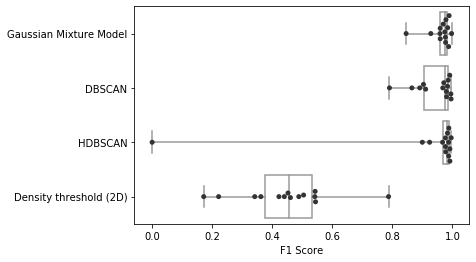

In [16]:
def rename_method(x):
    if x == 'gmm_lymphocytes':
        return 'Gaussian Mixture Model'
    if x == 'dbscan_lymphocytes':
        return 'DBSCAN'
    if x == 'hdbscan_lymphocytes':
        return 'HDBSCAN'
    if x == 'dens2d_lymphocytes':
        return 'Density threshold (2D)'
    return x
gating_performance['method'] = gating_performance['method'].apply(rename_method)
ax = sns.boxplot(x="f1_score", y="method", data=gating_performance, whis=np.inf, color='white')
ax = sns.swarmplot(x="f1_score", y="method", data=gating_performance, color=".2")
ax.set_xlabel('F1 Score')
ax.set_ylabel('')

Text(0, 0.5, '')

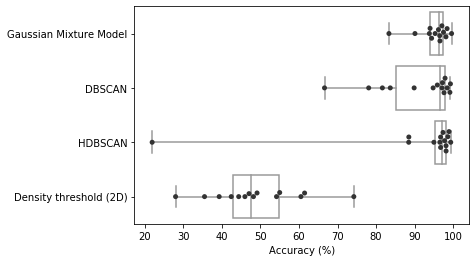

In [18]:
ax = sns.boxplot(x="accuracy", y="method", data=gating_performance, whis=np.inf, color='white')
ax = sns.swarmplot(x="accuracy", y="method", data=gating_performance, color=".2")
ax.set_xlabel('Accuracy (%)')
ax.set_ylabel('')

Text(0, 0.5, '')

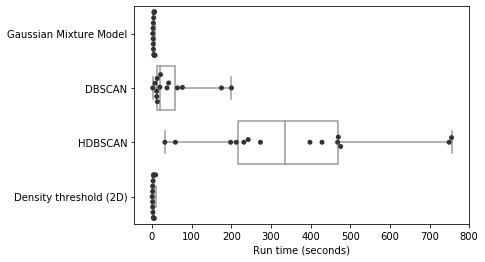

In [19]:
ax = sns.boxplot(x="time", y="method", data=gating_performance, whis=np.inf, color='white')
ax = sns.swarmplot(x="time", y="method", data=gating_performance, color=".2")
ax.set_xlabel('Run time (seconds)')
ax.set_ylabel('')